In [1]:
from importlib import reload
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gp
import torch

import omegaconf
from loguru import logger
from omegaconf import DictConfig, OmegaConf
import hydra
from progressbar import progressbar as pbar

from earthtext.datamodules import chipmultilabel

from importlib import reload
reload(chipmultilabel)

from earthtext.osm import multilabel
name_dict = multilabel.kvmerged.inverse_codes

In [2]:
from sklearn.metrics import precision_score, recall_score

tpr = lambda y_true, y_pred: np.mean(y_true[y_true==1] == y_pred[y_true==1])
prec = lambda y_true, y_pred: sum(y_true[y_pred==1]) / sum(y_pred==1) if sum(y_pred==1)>0 else None
metr = lambda y_true, y_pred: {'tpr': tpr(y_true, y_pred), 'prec': prec(y_true, y_pred)}

In [38]:
def mod_df(df, ix, c):
    arr_count = np.stack(df.loc[ix, 'onehot_count'])
    arr_count[:, c] = 0
    series_count = pd.Series(list(arr_count), index=ix)  # convert to series of arrays
    
    arr_area = np.stack(df.loc[ix, 'onehot_area'])
    arr_area[:, c] = 0
    series_area = pd.Series(list(arr_area), index=ix)  # convert to series of arrays
    
    arr_length = np.stack(df.loc[ix, 'onehot_length'])
    arr_length[:, c] = 0
    series_length = pd.Series(list(arr_length), index=ix)  # convert to series of arrays

    df.loc[ix, 'onehot_count'] = series_count
    df.loc[ix, 'onehot_area'] = series_area
    df.loc[ix, 'onehot_length'] = series_length

# Train on all OSM classes

In [2]:
conf = OmegaConf.load("../../configs/multilabel.yaml")
conf.dataloader.batch_size = 16
dl = hydra.utils.instantiate(conf.dataloader)

2024-05-01 16:17:59.260 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1088 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-05-01 16:18:02.679 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1092 - read train split with 58599 chip files (out of 58690)
2024-05-01 16:18:02.680 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1097 - max cache size is -1
2024-05-01 16:18:03.057 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1088 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-05-01 16:18:03.726 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1092 - read val split with 11822 chip files (out of 11841)
2024-05-01 16:18:03.726 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1097 - max cache size is -1
2024-05-

In [3]:
dltrain = dl.train_dataloader()
m = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)
sum([np.product(p.shape) for p in m.parameters()])

570723

---

In [4]:
n_epochs = 50

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = batch['embedding']
        t = batch['multilabel']

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = - torch.mean(torch.log(o + 1e-5)*t + torch.log(1-o + 1e-5)*(1-t))
        
        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 3662 loss 0.16786 params 0.0364581
epoch   1 step 3662 loss 0.15898 params 0.0535343
epoch   2 step 3662 loss 0.15218 params 0.0776345
epoch   3 step 3662 loss 0.15730 params 0.1023680
epoch   4 step 3662 loss 0.14771 params 0.1271909
epoch   5 step 3662 loss 0.14300 params 0.1523066
epoch   6 step 3662 loss 0.15111 params 0.1779782
epoch   7 step 3662 loss 0.13661 params 0.2040961
epoch   8 step 3662 loss 0.14101 params 0.2305158
epoch   9 step 3662 loss 0.14393 params 0.2568380
epoch  10 step 3662 loss 0.13020 params 0.2834253
epoch  11 step 3662 loss 0.13871 params 0.3100521
epoch  12 step 3662 loss 0.13755 params 0.3365520
epoch  13 step 3662 loss 0.13815 params 0.3630856
epoch  14 step 3662 loss 0.13850 params 0.3896684
epoch  15 step 3662 loss 0.13435 params 0.4162102
epoch  16 step 3662 loss 0.14209 params 0.4428231
epoch  17 step 3662 loss 0.13348 params 0.4693492
epoch  18 step 3662 loss 0.13848 params 0.4956720
epoch  19 step 3662 loss 0.14292 params 0.5217057


KeyboardInterrupt: 

Text(0, 0.5, 'loss')

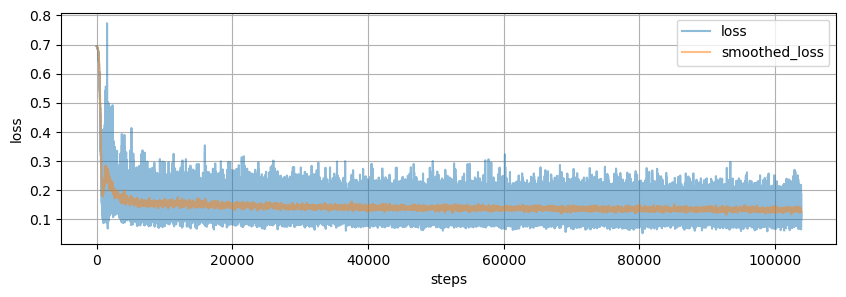

In [5]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")

In [6]:
targets = []
predictions = []
dltrain = dl.train_dataloader()
for batch in pbar(dltrain):
    x = batch['embedding']
    t = batch['multilabel']

    o = m(x)

    for ti in t.detach().numpy():
        targets.append(ti)

    for oi in o.detach().numpy():
        predictions.append(oi)
    
targets = np.r_[targets]
predictions = np.r_[predictions]
targets.shape, predictions.shape

100% (3663 of 3663) |####################| Elapsed Time: 0:00:13 Time:  0:00:130001


((58599, 99), (58599, 99))

In [7]:
idxs = np.random.permutation(len(targets))[:300]

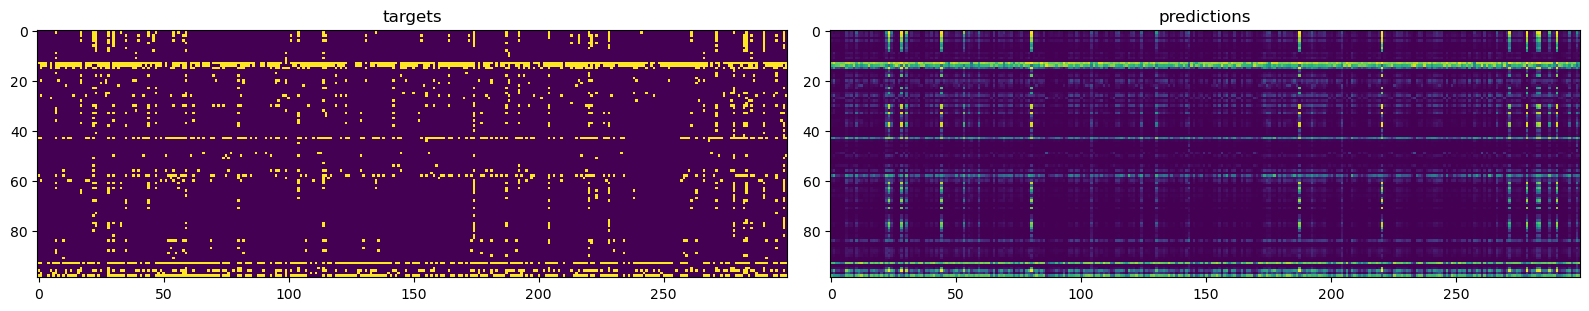

In [8]:
for ax, i in subplots(2, usizex=8):
    if i==0: 
        plt.imshow(targets[idxs].T, interpolation='none')
        plt.title("targets")
    if i==1:
        plt.imshow(predictions[idxs].T, interpolation='none', vmin=0, vmax=1)
        plt.title("predictions")
        #plt.colorbar();

In [9]:
from sklearn.metrics import precision_score, recall_score

tpr = lambda y_true, y_pred: np.mean(y_true[y_true==1] == y_pred[y_true==1])
tnr = lambda y_true, y_pred: np.mean(y_true[y_true==0] == y_pred[y_true==0])
prec = lambda y_true, y_pred: sum(y_true[y_pred==1]) / sum(y_pred==1) if sum(y_pred==1)>0 else None

acc = lambda y_true, y_pred: np.mean(y_true==y_pred)
metr = lambda y_true, y_pred: {'tpr': tpr(y_true, y_pred),
                               'prec': prec(y_true, y_pred)}

In [10]:
metr(targets.flatten(), predictions.flatten()>.5)

{'tpr': 0.5049786837131849, 'prec': 0.7197817113661834}

In [11]:
precision_score(targets.flatten(), predictions.flatten()>.5), \
recall_score(targets.flatten(), predictions.flatten()>.5)

(0.7197817113661834, 0.5049786837131849)

In [12]:
r = [metr(targets[:,c], predictions[:,c]>.5) for c in range(targets.shape[-1])]    
r = pd.DataFrame(r)

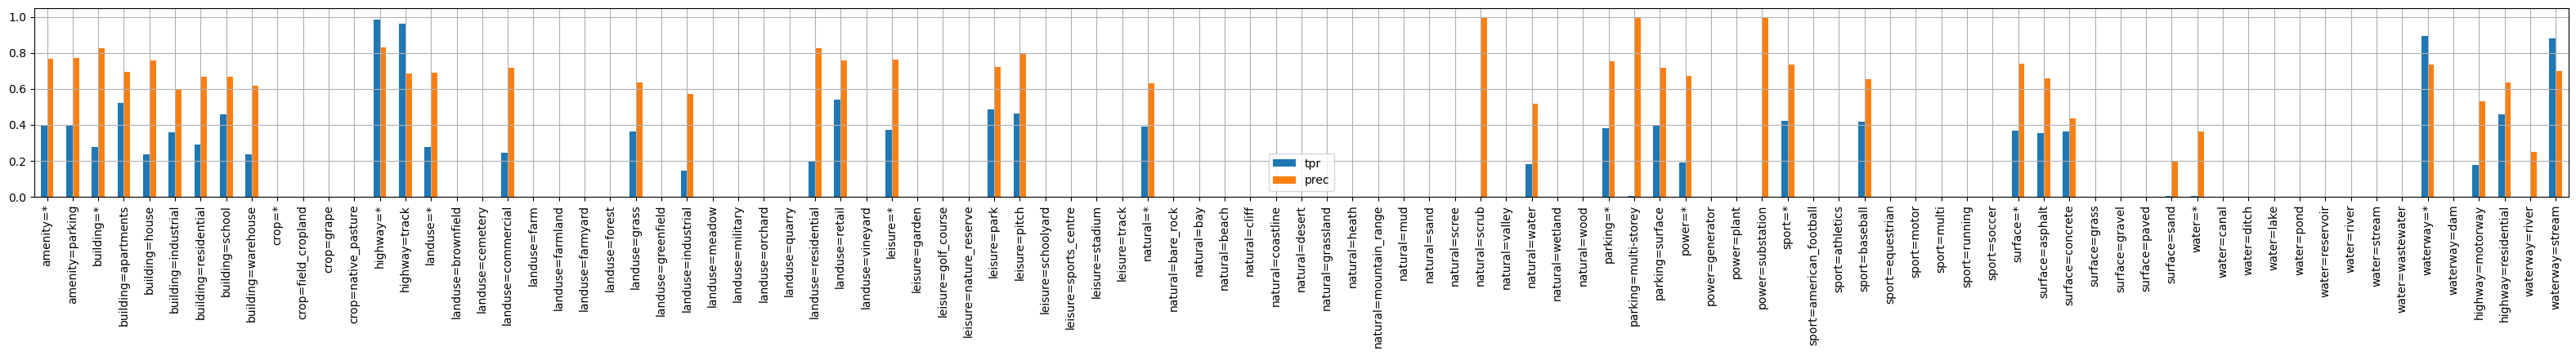

In [13]:
ax = r[['tpr', 'prec']].plot(kind='bar', figsize=(40,3))
plt.grid()
ax.set_xticklabels(labels=(name_dict[i] for i in range(99)), rotation=90, fontsize=10);

In [ ]:
# classes_retain = [0, 1, 2, 3, 4, 5, 6, 7, 8, 13,
#                   14, 15, 18, 20, 23, 25, 30, 31, 33, 37,
#                   38, 43, 58, 61, 63, 64, 68, 71, 77, 78,
#                   87, 93, 95, 96, 98]

In [ ]:
# ax = r[['tpr', 'prec']].plot(kind='scatter', x='tpr', y='prec', c='gray', figsize=(10,10))

# for i in range(len(np.array(r.tpr))):
#     if not np.isnan(np.array(r.prec)[i]):
#         ax.text(x=np.array(r.tpr)[i], y=np.array(r.prec)[i], s=name_dict[list(r.index)[i]], size=10)

---

In [14]:
R = []
for thres in pbar(np.linspace(0, .99, 100)):
    r = [metr(targets[:,c], predictions[:,c] >= thres) for c in range(targets.shape[-1])]    
    r = pd.DataFrame(r)
    R.append(r)

R = np.array([r.values for r in R])
R.shape

100% (100 of 100) |######################| Elapsed Time: 0:01:35 Time:  0:01:350008


(100, 99, 2)

In [ ]:
# fig = plt.figure(figsize=(10, 2));
# # print(targets[:, c].sum())
# c = 1
# plt.hist(predictions[:, c], bins=100);
# plt.hist(predictions[targets[:, c] > 0, c], bins=100, color='lightgreen');
# plt.plot(np.linspace(0, .99, 100), R[:, c, 1]*100, '--');
# plt.yscale('log'); plt.xlabel('prediction prob'); plt.xlim(0,1);

# i_nz = (R[:, c, 1] >= .8).nonzero()[0][0]
# plt.plot(i_nz/100, R[i_nz, c, 1]*100, 'o', color='orange');

Classes to retain based on the below

In [7]:
classes_retain = [2, 3, 4, 5, 6, 7, 8, 13, 14, 18,
                  23, 30, 33, 37, 43, 58, 61, 68, 71, 84,
                  93, 95, 96, 98]

print(len(classes_retain))
for c in classes_retain:
    print(c, name_dict[c])

24
2 building=*
3 building=apartments
4 building=house
5 building=industrial
6 building=residential
7 building=school
8 building=warehouse
13 highway=*
14 highway=track
18 landuse=commercial
23 landuse=grass
30 landuse=residential
33 leisure=*
37 leisure=park
43 natural=*
58 natural=water
61 parking=*
68 sport=*
71 sport=baseball
84 water=*
93 waterway=*
95 highway=motorway
96 highway=residential
98 waterway=stream


<Figure size 640x480 with 0 Axes>

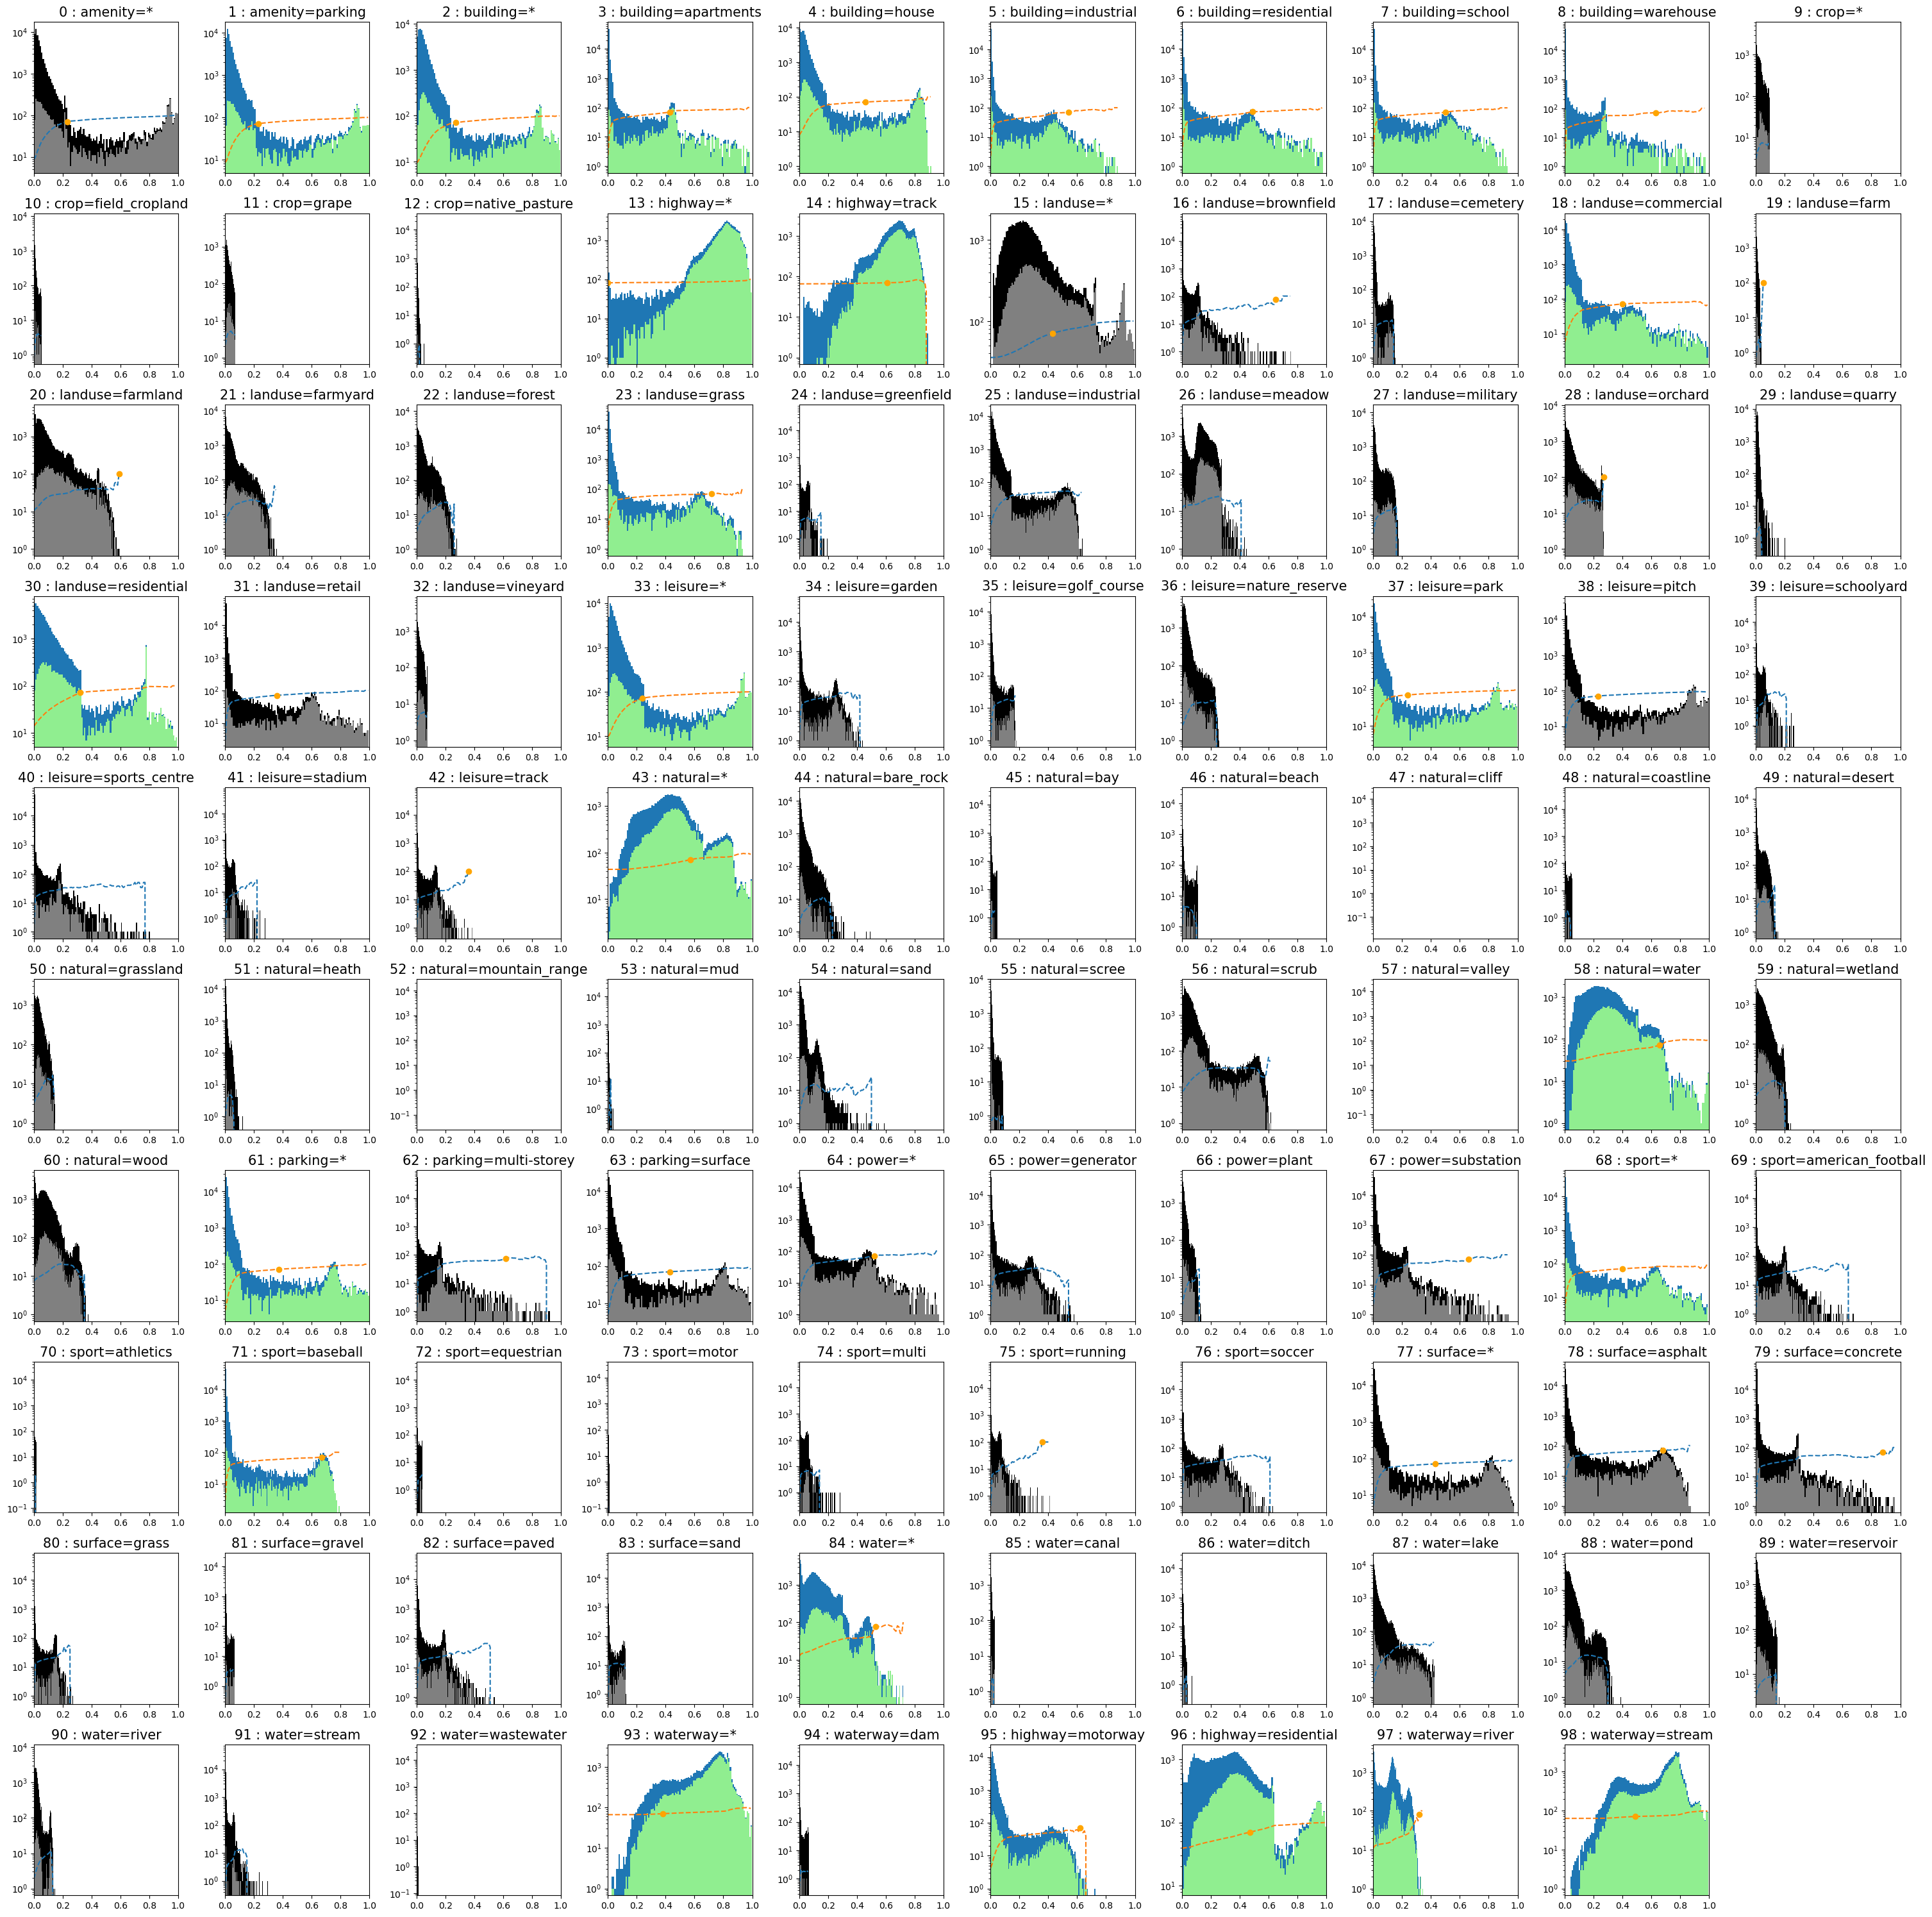

In [265]:
fig = plt.figure();
for ax, c in subplots(99, n_cols=10, usizex=3, usizey=3):
    if c in classes_retain:
        plt.hist(predictions[:, c], bins=100);
        plt.hist(predictions[targets[:, c] > 0, c], bins=100, color='lightgreen');
    else:
        plt.hist(predictions[:, c], bins=100, color='black');
        plt.hist(predictions[targets[:, c] > 0, c], bins=100, color='gray');
    plt.plot(np.linspace(0, .99, 100), R[:, c, 1]*100, '--');
    is_high_prec = (R[:, c, 1] >= .7)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        plt.plot(i_nz/100, R[i_nz, c, 1]*100, 'o', color='orange');
    plt.yscale('log');
    plt.xlim(0,1); plt.title(f"{c} : {name_dict[c]}", fontsize=15);

<Figure size 640x480 with 0 Axes>

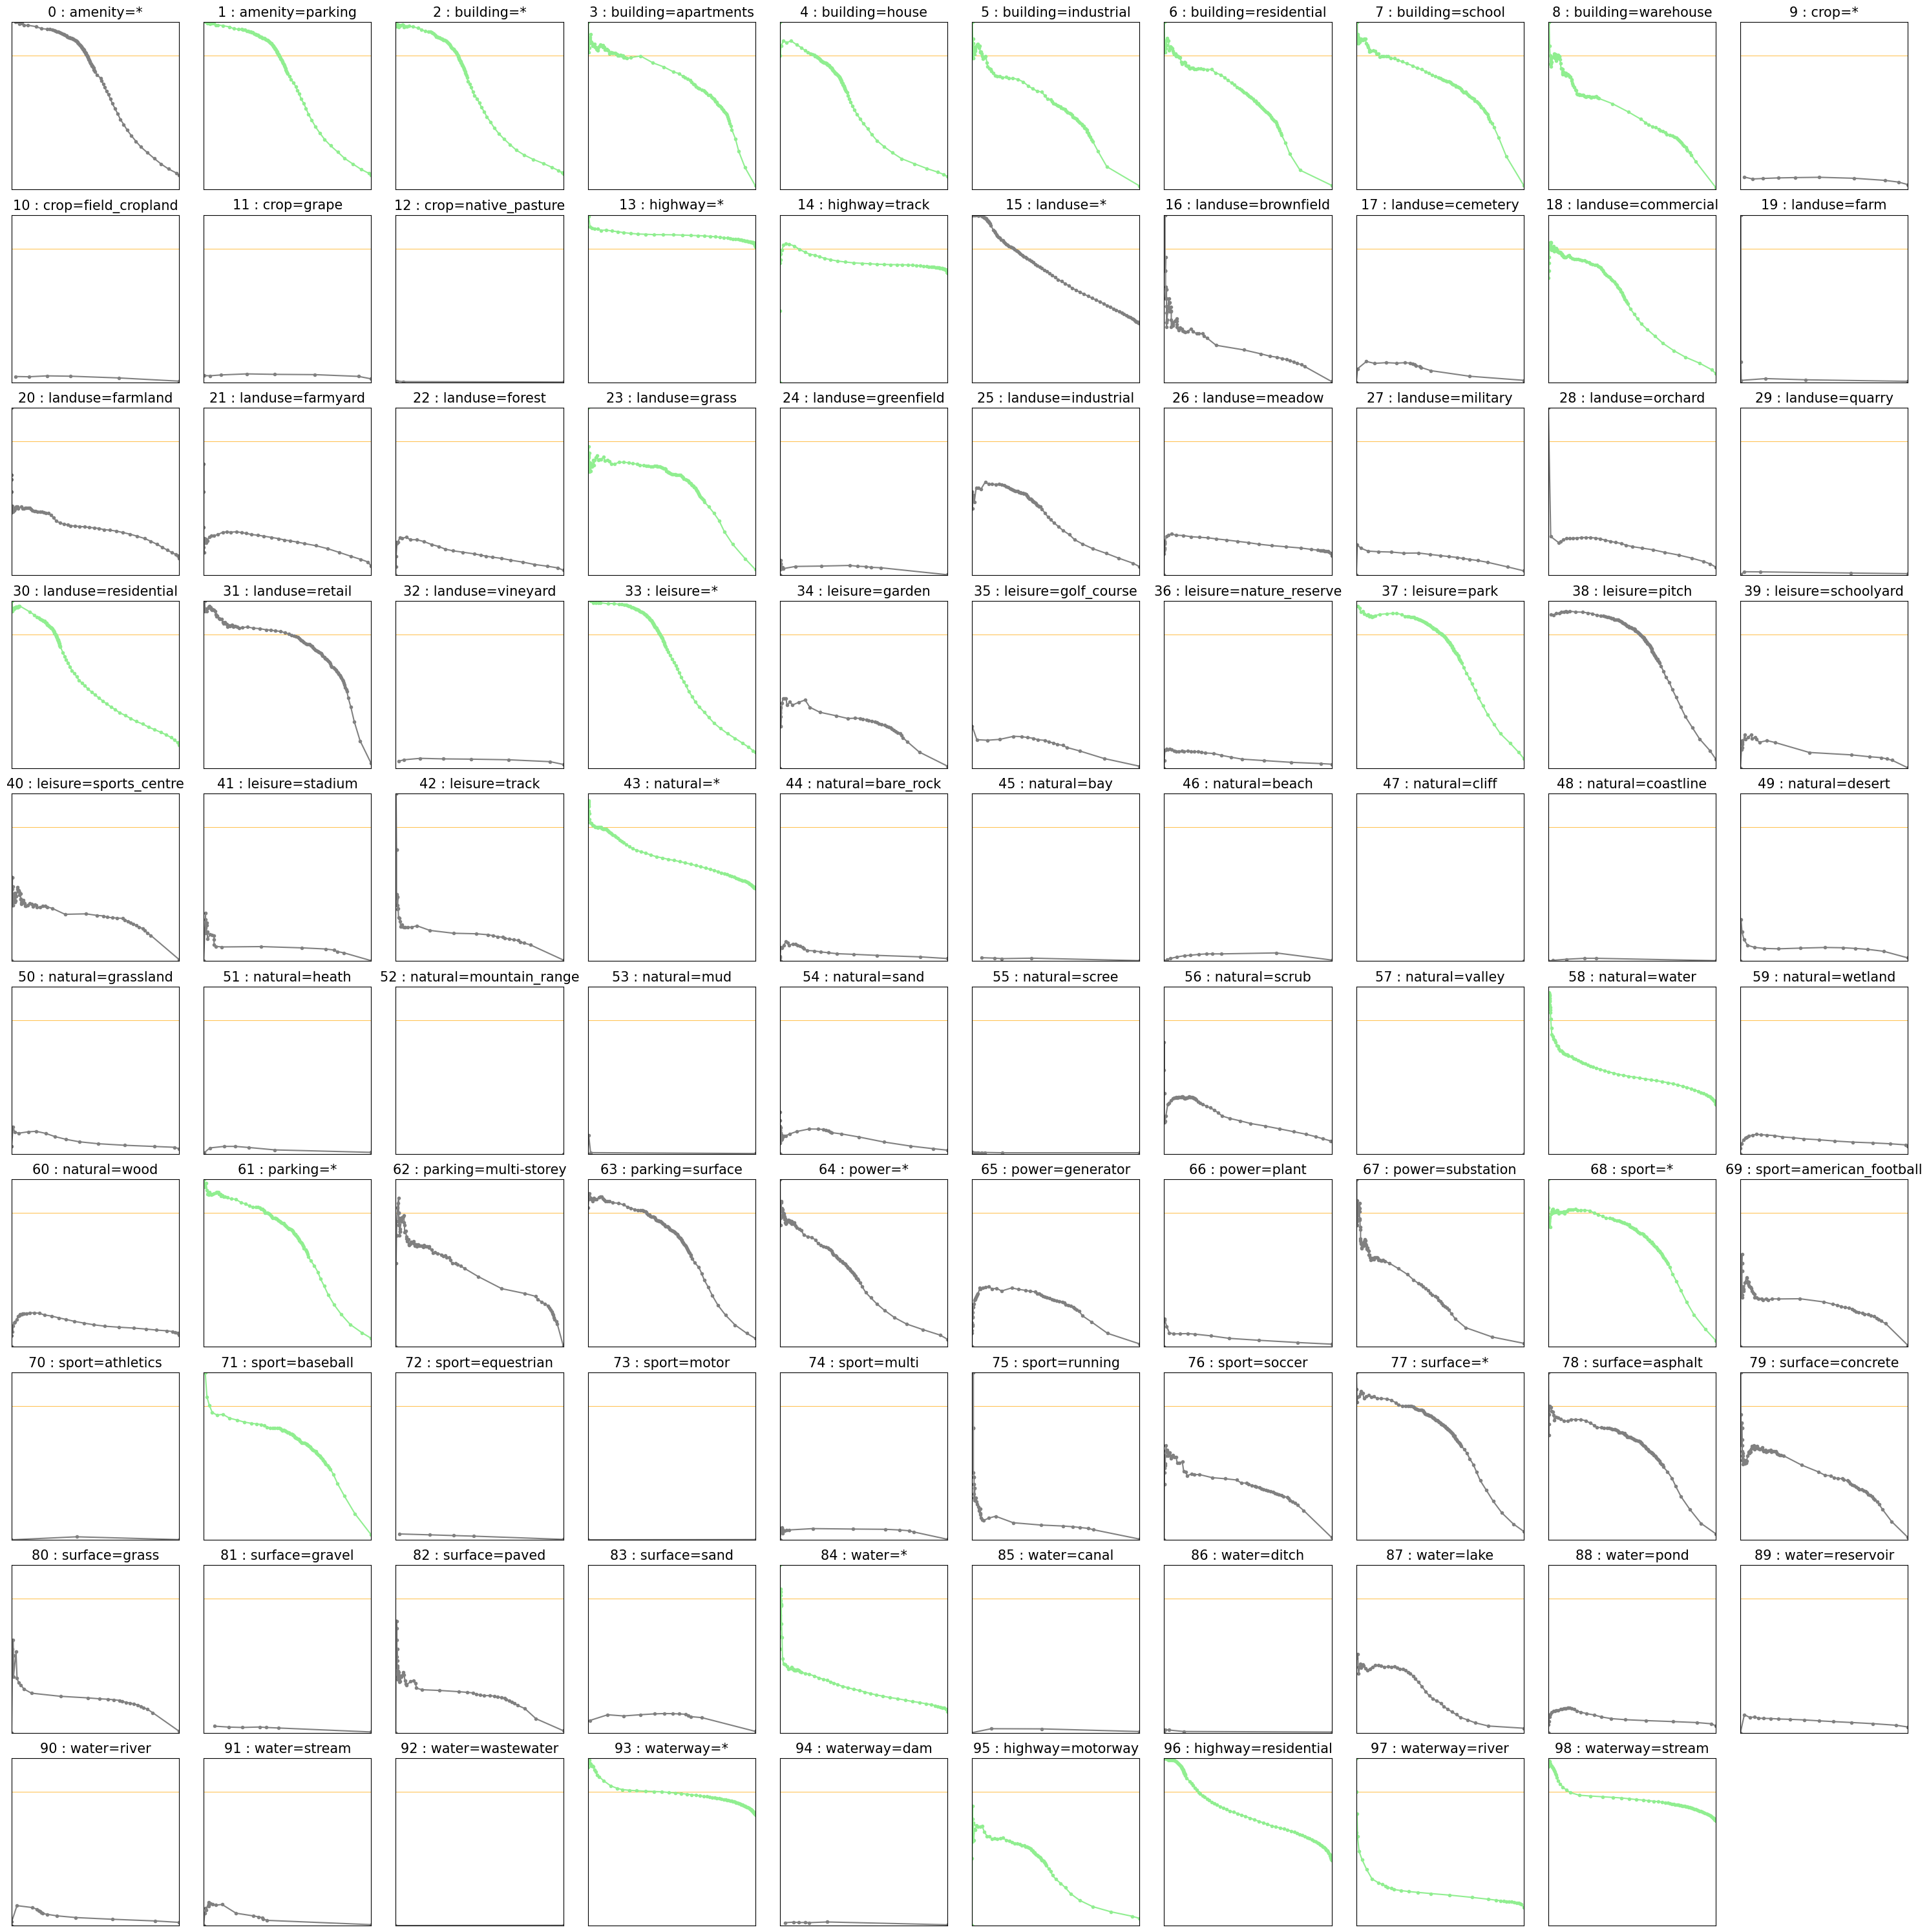

In [266]:
fig = plt.figure();
for ax, c in subplots(99, n_cols=10, usizex=3, usizey=3):
    ax.plot([0,1], [.8,.8], lw=.5, c='orange');
    ax.set_title(f"{c} : {name_dict[c]}", fontsize=15);
    ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_yticks([]); ax.set_xticks([]); ax.set_aspect('equal');
    if c in classes_retain:
        ax.plot(*R[:, c, :].T, marker='o', ls='-', markersize=3, color='lightgreen');
    else:
        ax.plot(*R[:, c, :].T, marker='o', ls='-', markersize=3, color='gray');
plt.tight_layout();

Cut-off probabilities

In [19]:
prob_cutoff = {}
for c in classes_retain:
    is_high_prec = (R[:, c, 1] >= .3)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        prob_cutoff[c] = i_nz / 100
print(len(prob_cutoff))
print(prob_cutoff)

targets2 = targets.copy()
for c in prob_cutoff:
    i_alter = (predictions[:, c] < prob_cutoff[c])
    targets2[i_alter, c] = 0

25
{2: 0.1, 3: 0.04, 4: 0.12, 5: 0.07, 6: 0.08, 7: 0.05, 8: 0.1, 13: 0.0, 14: 0.0, 18: 0.11, 23: 0.07, 30: 0.16, 33: 0.11, 37: 0.08, 43: 0.0, 58: 0.02, 61: 0.07, 68: 0.06, 71: 0.06, 84: 0.25, 93: 0.0, 95: 0.1, 96: 0.0, 97: 0.3, 98: 0.0}


---

# Train on all OSM classes (emb v0.2-20240426)

In [3]:
conf = OmegaConf.load("../../configs/multilabel.yaml")
conf.dataloader.batch_size = 16
conf.dataloader.embeddings_folder = "/opt/data/california-worldcover-chips/embeddings_v0.2-20240426"
dl = hydra.utils.instantiate(conf.dataloader)

2024-05-02 23:36:56.184 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1088 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-05-02 23:36:59.533 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1092 - read train split with 58599 chip files (out of 58690)
2024-05-02 23:36:59.534 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1097 - max cache size is -1
2024-05-02 23:37:00.018 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1088 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-05-02 23:37:00.681 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1092 - read val split with 11822 chip files (out of 11841)
2024-05-02 23:37:00.682 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1097 - max cache size is -1
2024-05-

In [4]:
dltrain = dl.train_dataloader()
m = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)
sum([np.product(p.shape) for p in m.parameters()])

570723

---

In [5]:
n_epochs = 50

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = batch['embedding']
        t = batch['multilabel']

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = - torch.mean(torch.log(o + 1e-5)*t + torch.log(1-o + 1e-5)*(1-t))
        
        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 3662 loss 0.17088 params 0.0373385
epoch   1 step 3662 loss 0.15428 params 0.0539383
epoch   2 step 3662 loss 0.15531 params 0.0776853
epoch   3 step 3662 loss 0.14726 params 0.1005679
epoch   4 step 3662 loss 0.15349 params 0.1232315
epoch   5 step 3662 loss 0.15094 params 0.1464422
epoch   6 step 3662 loss 0.14364 params 0.1706412
epoch   7 step 3662 loss 0.15123 params 0.1962835
epoch   8 step 3662 loss 0.14444 params 0.2224442
epoch   9 step 3662 loss 0.13458 params 0.2486245
epoch  10 step 3662 loss 0.14402 params 0.2748316
epoch  11 step 3662 loss 0.14822 params 0.3011219
epoch  12 step 3662 loss 0.14552 params 0.3276494
epoch  13 step 3662 loss 0.13924 params 0.3542570
epoch  14 step 3662 loss 0.14112 params 0.3809033
epoch  15 step 3662 loss 0.13716 params 0.4072006
epoch  16 step 3662 loss 0.13053 params 0.4333650
epoch  17 step 3662 loss 0.13830 params 0.4592210
epoch  18 step 3662 loss 0.13604 params 0.4851089
epoch  19 step 3662 loss 0.13959 params 0.5110717


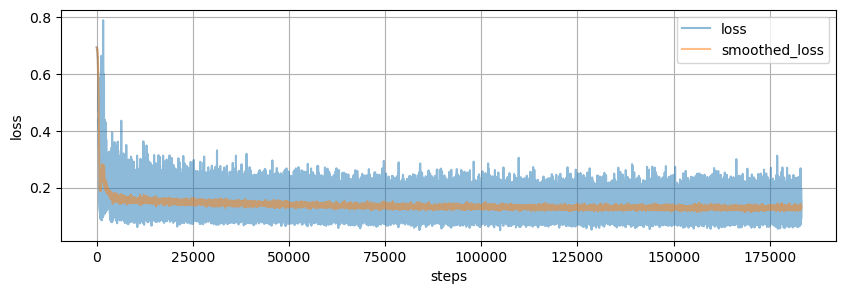

In [6]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss");

In [7]:
targets = []
predictions = []
dltrain = dl.train_dataloader()
for batch in pbar(dltrain):
    x = batch['embedding']
    t = batch['multilabel']

    o = m(x)

    for ti in t.detach().numpy():
        targets.append(ti)

    for oi in o.detach().numpy():
        predictions.append(oi)
    
targets = np.r_[targets]
predictions = np.r_[predictions]
targets.shape, predictions.shape

100% (3663 of 3663) |####################| Elapsed Time: 0:00:12 Time:  0:00:120001


((58599, 99), (58599, 99))

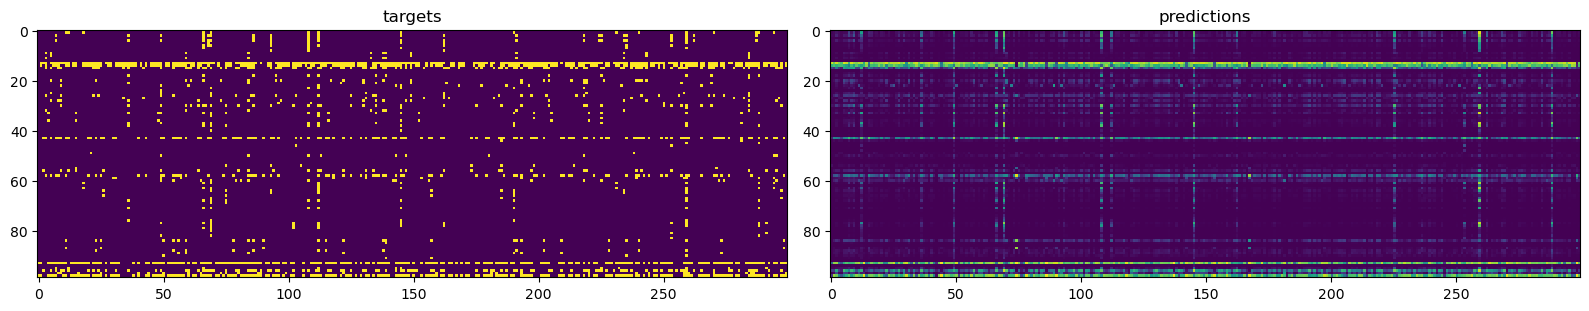

In [8]:
idxs = np.random.permutation(len(targets))[:300]

for ax, i in subplots(2, usizex=8):
    if i==0: 
        plt.imshow(targets[idxs].T, interpolation='none')
        plt.title("targets")
    if i==1:
        plt.imshow(predictions[idxs].T, interpolation='none', vmin=0, vmax=1)
        plt.title("predictions")
        #plt.colorbar();

In [9]:
metr(targets.flatten(), predictions.flatten()>.5)

{'tpr': 0.529403290472865, 'prec': 0.7200094312053346}

In [10]:
precision_score(targets.flatten(), predictions.flatten()>.5), \
recall_score(targets.flatten(), predictions.flatten()>.5)

(0.7200094312053346, 0.529403290472865)

In [11]:
r = [metr(targets[:,c], predictions[:,c]>.5) for c in range(targets.shape[-1])]    
r = pd.DataFrame(r)

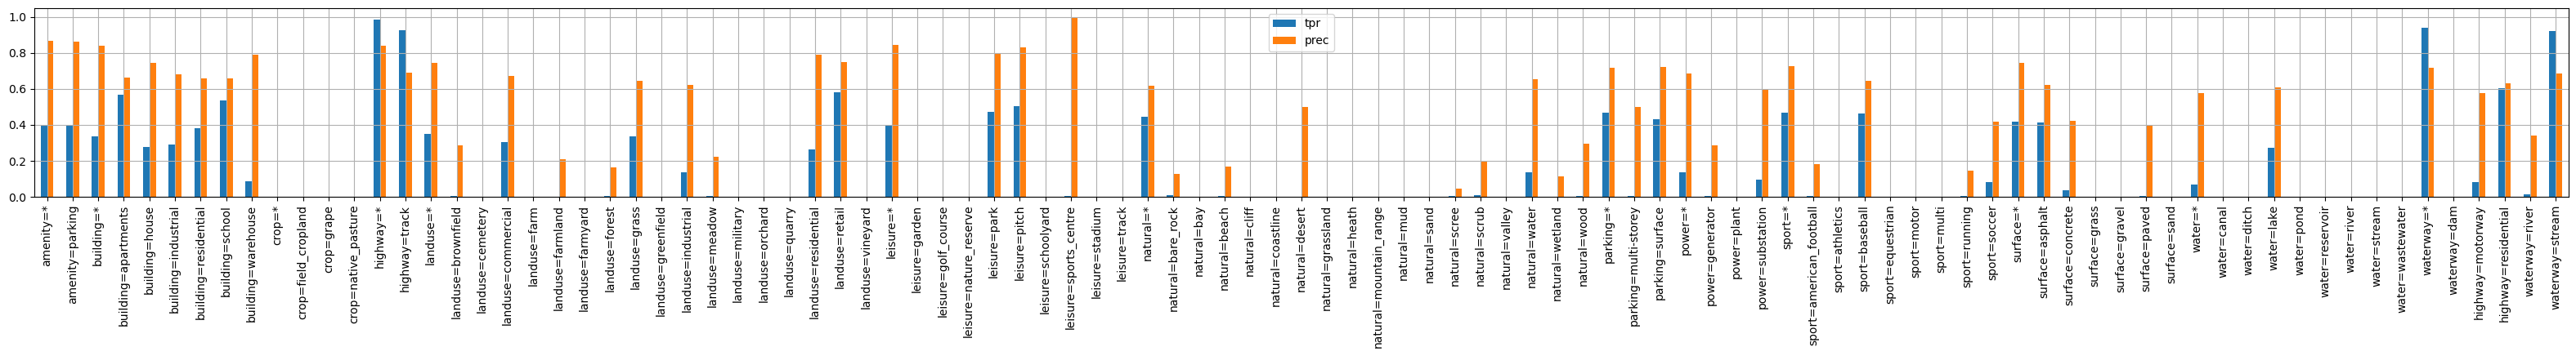

In [12]:
ax = r[['tpr', 'prec']].plot(kind='bar', figsize=(40,3))
plt.grid()
ax.set_xticklabels(labels=(name_dict[i] for i in range(99)), rotation=90, fontsize=10);

In [13]:
R = []
for thres in pbar(np.linspace(0, .99, 100)):
    r = [metr(targets[:,c], predictions[:,c] >= thres) for c in range(targets.shape[-1])]    
    r = pd.DataFrame(r)
    R.append(r)

R = np.array([r.values for r in R])
R.shape

100% (100 of 100) |######################| Elapsed Time: 0:01:49 Time:  0:01:490110


(100, 99, 2)

In [ ]:
# fig = plt.figure(figsize=(10, 2));
# # print(targets[:, c].sum())
# c = 1
# plt.hist(predictions[:, c], bins=100);
# plt.hist(predictions[targets[:, c] > 0, c], bins=100, color='lightgreen');
# plt.plot(np.linspace(0, .99, 100), R[:, c, 1]*100, '--');
# plt.yscale('log'); plt.xlabel('prediction prob'); plt.xlim(0,1);

# i_nz = (R[:, c, 1] >= .8).nonzero()[0][0]
# plt.plot(i_nz/100, R[i_nz, c, 1]*100, 'o', color='orange');

Classes to retain based on the below

In [14]:
classes_retain = [2, 3, 4, 5, 6, 7, 8, 13, 14, 18,
                  23, 30, 33, 37, 43, 58, 61, 68, 71, 84,
                  93, 95, 96, 98]

print(len(classes_retain))
for c in classes_retain:
    print(c, name_dict[c])

24
2 building=*
3 building=apartments
4 building=house
5 building=industrial
6 building=residential
7 building=school
8 building=warehouse
13 highway=*
14 highway=track
18 landuse=commercial
23 landuse=grass
30 landuse=residential
33 leisure=*
37 leisure=park
43 natural=*
58 natural=water
61 parking=*
68 sport=*
71 sport=baseball
84 water=*
93 waterway=*
95 highway=motorway
96 highway=residential
98 waterway=stream


<Figure size 640x480 with 0 Axes>

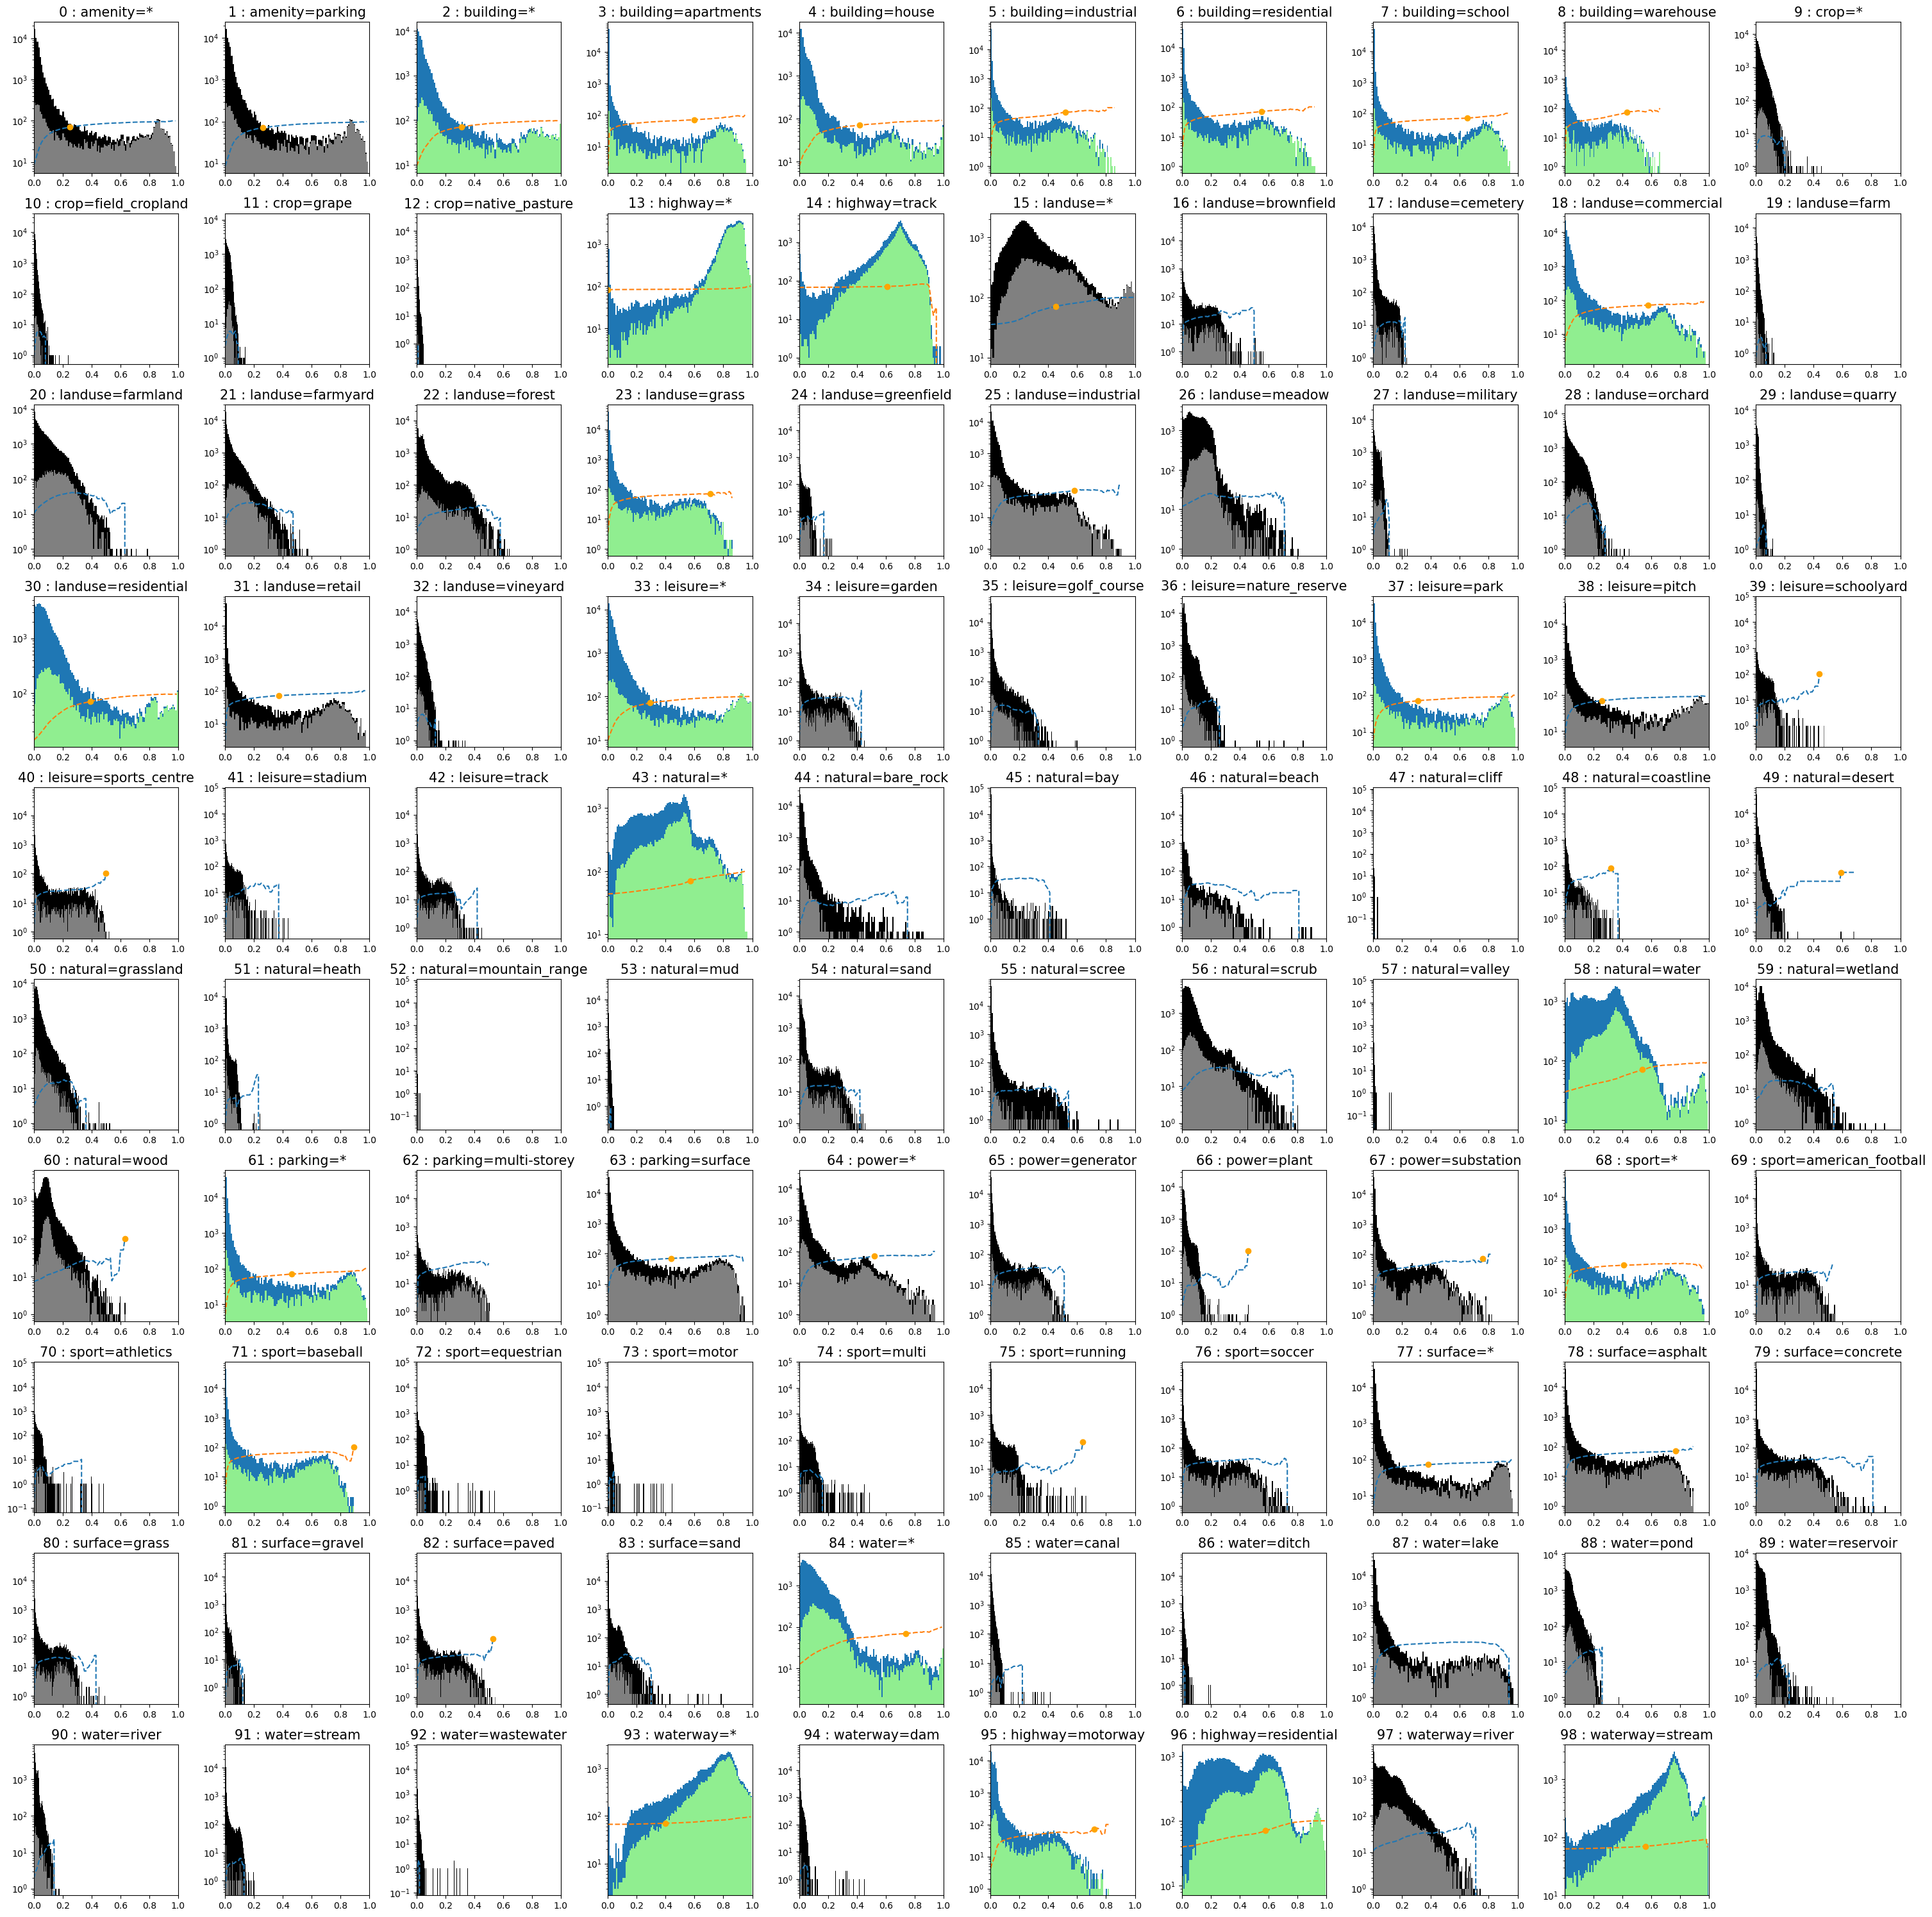

In [15]:
fig = plt.figure();
for ax, c in subplots(99, n_cols=10, usizex=3, usizey=3):
    if c in classes_retain:
        plt.hist(predictions[:, c], bins=100);
        plt.hist(predictions[targets[:, c] > 0, c], bins=100, color='lightgreen');
    else:
        plt.hist(predictions[:, c], bins=100, color='black');
        plt.hist(predictions[targets[:, c] > 0, c], bins=100, color='gray');
    plt.plot(np.linspace(0, .99, 100), R[:, c, 1]*100, '--');
    is_high_prec = (R[:, c, 1] >= .7)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        plt.plot(i_nz/100, R[i_nz, c, 1]*100, 'o', color='orange');
    plt.yscale('log');
    plt.xlim(0,1); plt.title(f"{c} : {name_dict[c]}", fontsize=15);

<Figure size 640x480 with 0 Axes>

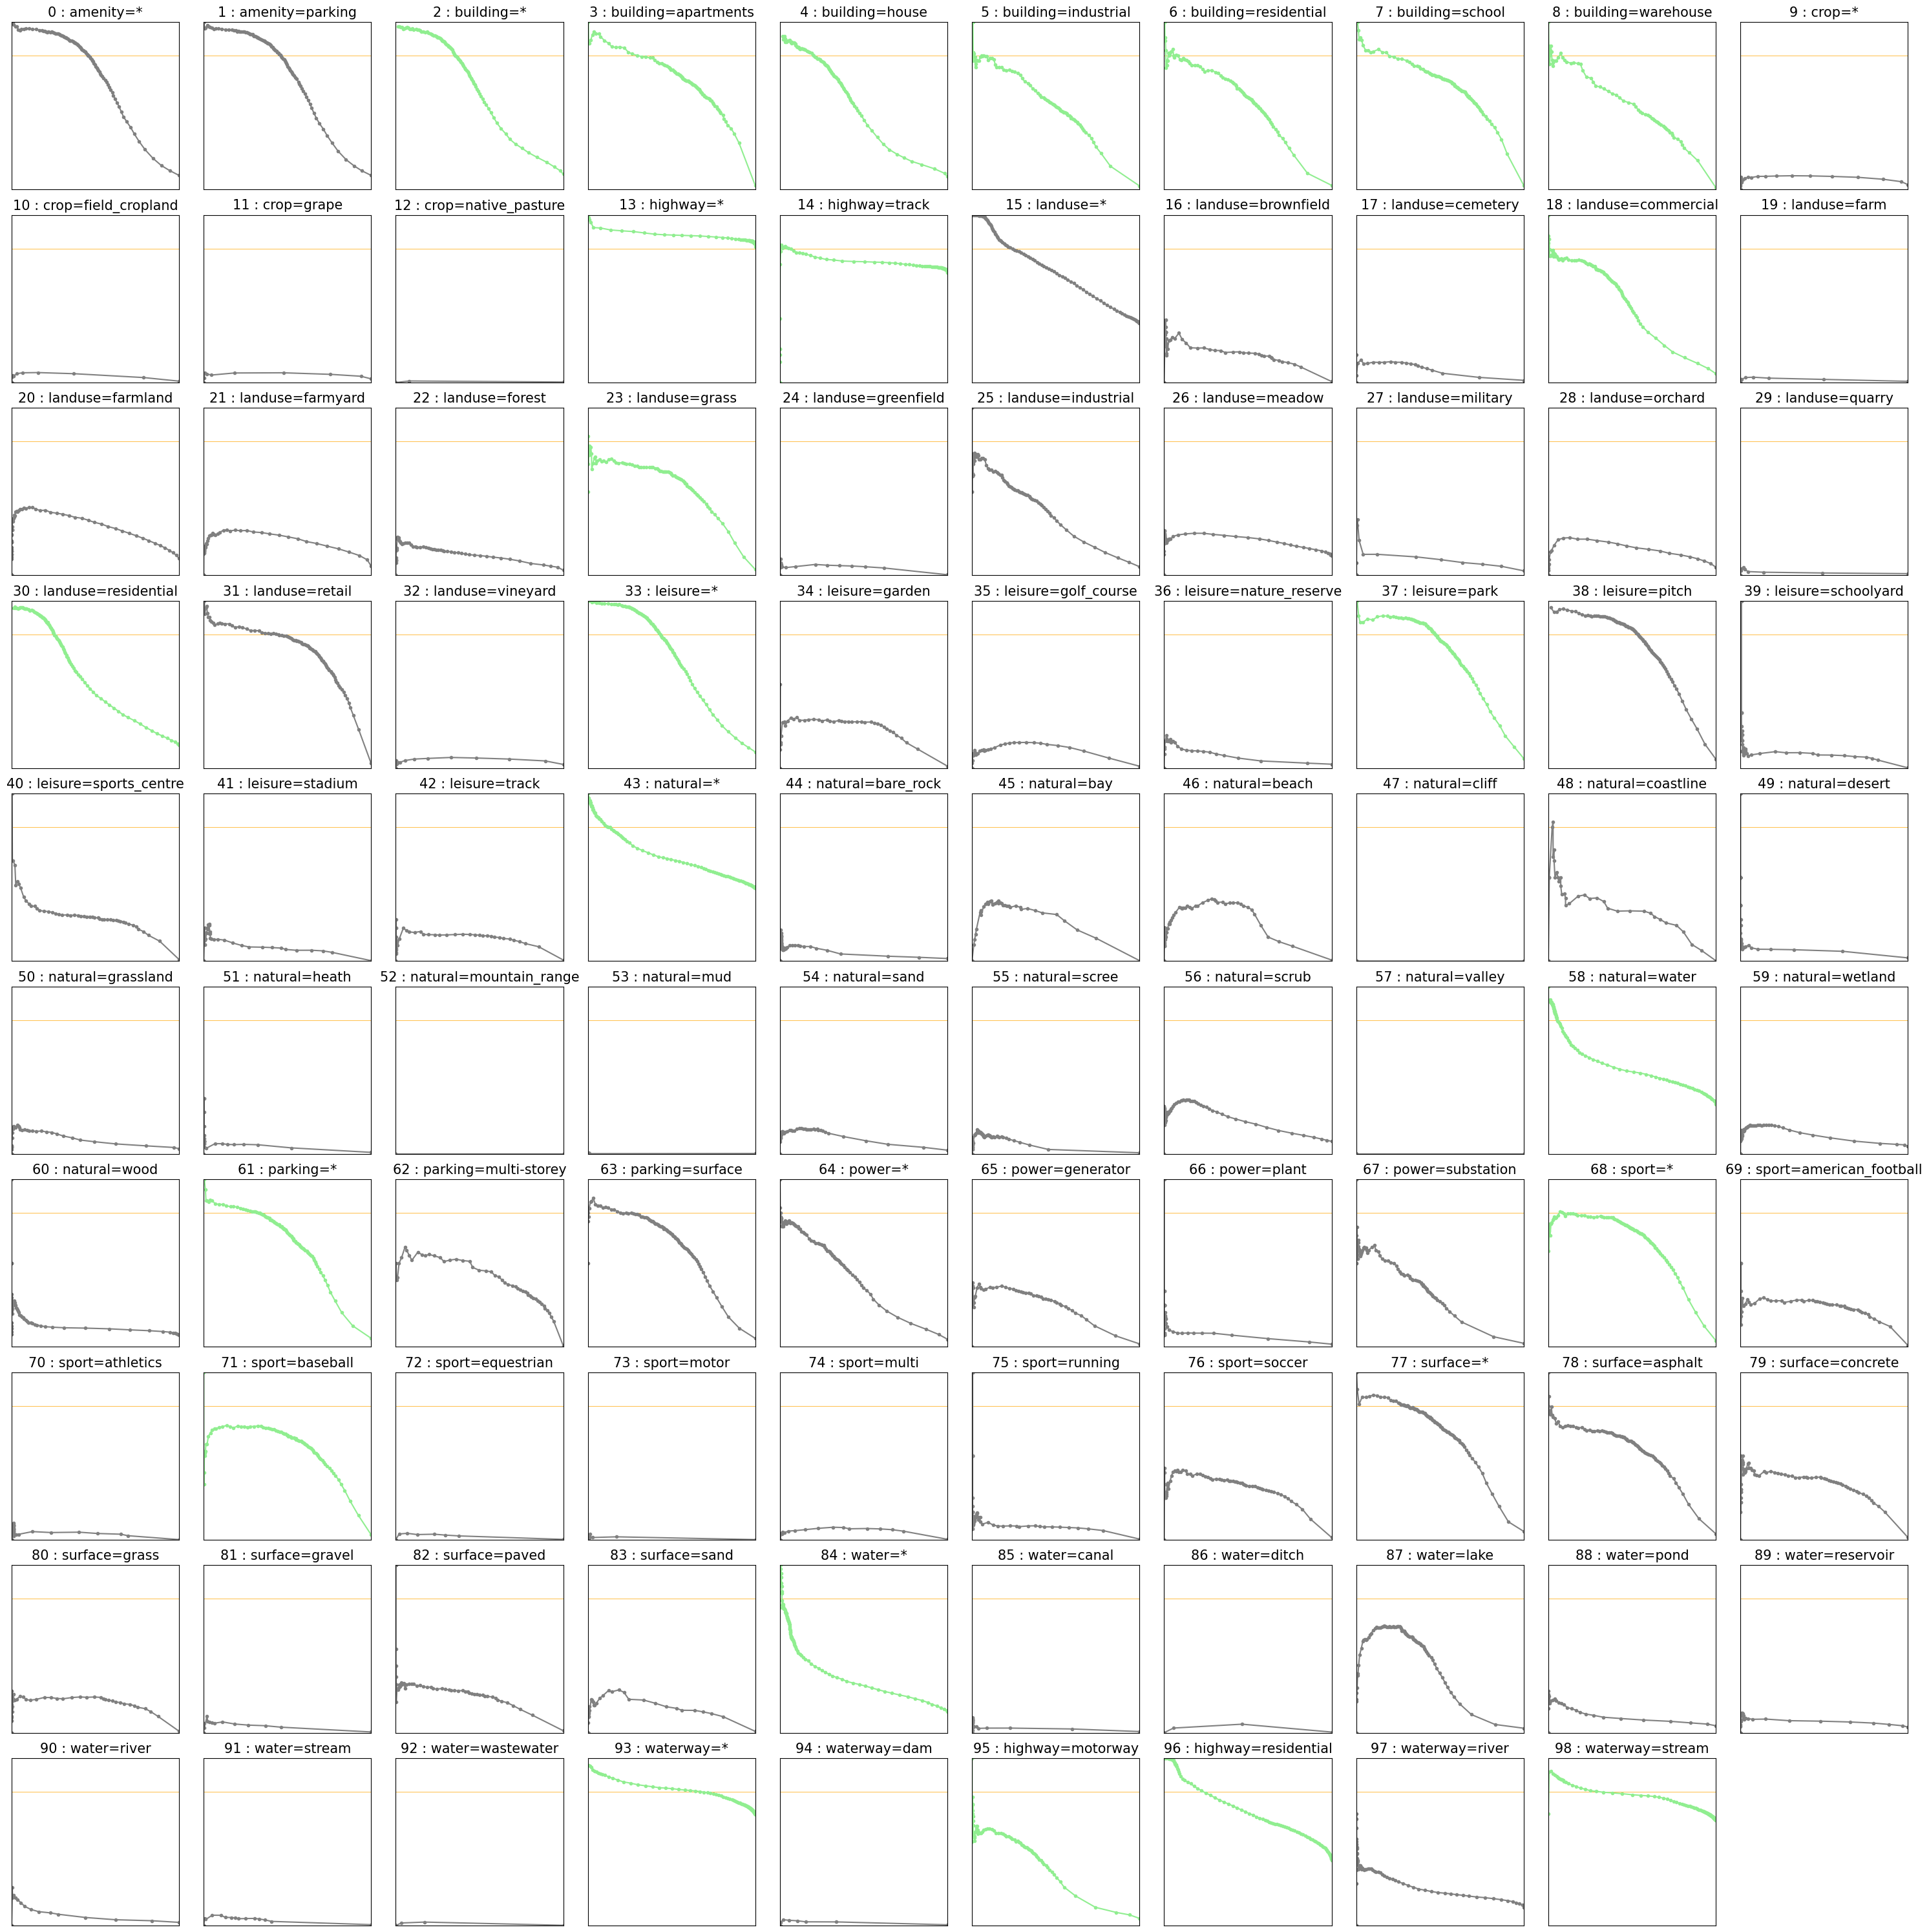

In [16]:
fig = plt.figure();
for ax, c in subplots(99, n_cols=10, usizex=3, usizey=3):
    ax.plot([0,1], [.8,.8], lw=.5, c='orange');
    ax.set_title(f"{c} : {name_dict[c]}", fontsize=15);
    ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_yticks([]); ax.set_xticks([]); ax.set_aspect('equal');
    if c in classes_retain:
        ax.plot(*R[:, c, :].T, marker='o', ls='-', markersize=3, color='lightgreen');
    else:
        ax.plot(*R[:, c, :].T, marker='o', ls='-', markersize=3, color='gray');
plt.tight_layout();

Cut-off probabilities

In [19]:
prob_cutoff = {}
for c in classes_retain:
    is_high_prec = (R[:, c, 1] >= .7)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        prob_cutoff[c] = i_nz / 100
print(len(prob_cutoff))
print(prob_cutoff)

targets2 = targets.copy()
for c in prob_cutoff:
    i_alter = (predictions[:, c] < prob_cutoff[c])
    targets2[i_alter, c] = 0

24
{2: 0.31, 3: 0.6, 4: 0.42, 5: 0.52, 6: 0.55, 7: 0.65, 8: 0.43, 13: 0.0, 14: 0.61, 18: 0.58, 23: 0.71, 30: 0.39, 33: 0.29, 37: 0.31, 43: 0.57, 58: 0.54, 61: 0.46, 68: 0.41, 71: 0.89, 84: 0.74, 93: 0.4, 95: 0.72, 96: 0.58, 98: 0.56}


# Train on retained OSM classes (emb v0.2-20240426)

In [20]:
classes_retain = [2, 3, 4, 5, 6, 7, 8, 13, 14, 18,
                  23, 30, 33, 37, 43, 58, 61, 68, 71, 84,
                  93, 95, 96, 98]

print(len(classes_retain))
for c in classes_retain:
    print(c, name_dict[c])

24
2 building=*
3 building=apartments
4 building=house
5 building=industrial
6 building=residential
7 building=school
8 building=warehouse
13 highway=*
14 highway=track
18 landuse=commercial
23 landuse=grass
30 landuse=residential
33 leisure=*
37 leisure=park
43 natural=*
58 natural=water
61 parking=*
68 sport=*
71 sport=baseball
84 water=*
93 waterway=*
95 highway=motorway
96 highway=residential
98 waterway=stream


In [21]:
conf = OmegaConf.load("../../configs/multilabel.yaml")
conf.dataloader.batch_size = 16
conf.model.output_dim = len(classes_retain)
conf.dataloader.embeddings_folder = "/opt/data/california-worldcover-chips/embeddings_v0.2-20240426"
dl = hydra.utils.instantiate(conf.dataloader)

2024-05-03 00:00:08.113 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1088 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-05-03 00:00:11.503 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1092 - read train split with 58599 chip files (out of 58690)
2024-05-03 00:00:11.503 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1097 - max cache size is -1
2024-05-03 00:00:11.862 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1088 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-05-03 00:00:12.544 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1092 - read val split with 11822 chip files (out of 11841)
2024-05-03 00:00:12.545 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1097 - max cache size is -1
2024-05-

In [22]:
dltrain = dl.train_dataloader()
m = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)
sum([np.product(p.shape) for p in m.parameters()])

561048

---

In [24]:
n_epochs = 100

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = batch['embedding']
        t = batch['multilabel'][:, classes_retain]

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = - torch.mean(torch.log(o + 1e-5)*t + torch.log(1-o + 1e-5)*(1-t))
        
        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 3662 loss 0.32924 params 0.0375818
epoch   1 step 3662 loss 0.30277 params 0.0554354
epoch   2 step 3662 loss 0.31510 params 0.0782855
epoch   3 step 3662 loss 0.30359 params 0.1019961
epoch   4 step 3662 loss 0.29532 params 0.1261492
epoch   5 step 3662 loss 0.28494 params 0.1506710
epoch   6 step 3662 loss 0.30306 params 0.1760577
epoch   7 step 3662 loss 0.28018 params 0.2017636
epoch   8 step 3662 loss 0.28325 params 0.2274532
epoch   9 step 3662 loss 0.28885 params 0.2536246
epoch  18 step 3662 loss 0.28441 params 0.4910237
epoch  19 step 3662 loss 0.28157 params 0.5165952
epoch  20 step 3662 loss 0.27835 params 0.5419830
epoch  21 step 3662 loss 0.27242 params 0.5671734
epoch  22 step 3662 loss 0.26471 params 0.5924215
epoch  23 step 3662 loss 0.27402 params 0.6174167
epoch  24 step 3662 loss 0.26990 params 0.6421900
epoch  25 step 3662 loss 0.25866 params 0.6667655
epoch  26 step 3662 loss 0.27796 params 0.6917139
epoch  27 step 3662 loss 0.26091 params 0.7164294


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



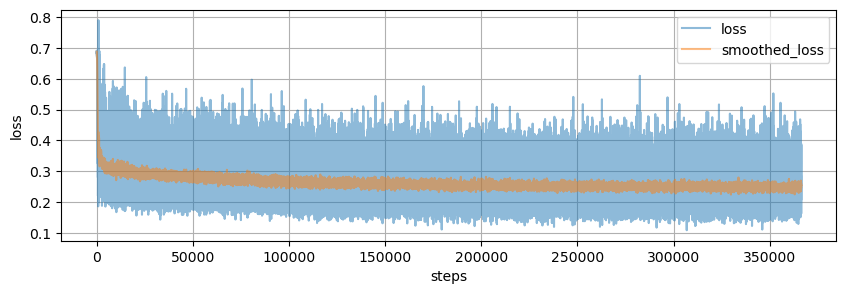

In [25]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss");

In [26]:
targets_train = []
predictions_train = []
embeddings_train = []
chip_IDs_train = []
dltrain = dl.train_dataloader()
for batch in pbar(dltrain):
    x = batch['embedding']
    t = batch['multilabel'][:, classes_retain]
    cid = batch['chip_id']

    o = m(x)

    for xi in x.detach().numpy():
        embeddings_train.append(xi)
    
    for ti in t.detach().numpy():
        targets_train.append(ti)

    for oi in o.detach().numpy():
        predictions_train.append(oi)

    chip_IDs_train.extend(cid)  # +=

embeddings_train = np.r_[embeddings_train]
targets_train = np.r_[targets_train]
predictions_train = np.r_[predictions_train]
chip_IDs_train = np.r_[chip_IDs_train]
embeddings_train.shape, targets_train.shape, predictions_train.shape, chip_IDs_train.shape

100% (3663 of 3663) |####################| Elapsed Time: 0:00:15 Time:  0:00:150001


((58599, 768), (58599, 24), (58599, 24), (58599,))

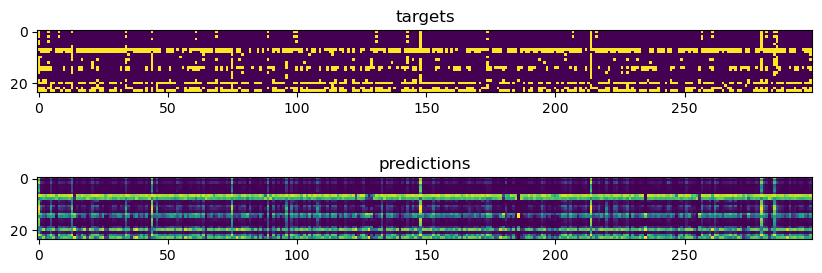

In [27]:
idxs = np.random.permutation(len(targets_train))[:300]

fig, ax = plt.subplots(2, 1, figsize=(10,3.5));
ax[0].imshow(targets_train[idxs].T, interpolation='none');
ax[0].set_title("targets");
ax[1].imshow(predictions_train[idxs].T, interpolation='none');
ax[1].set_title("predictions");
# fig.tight_layout()

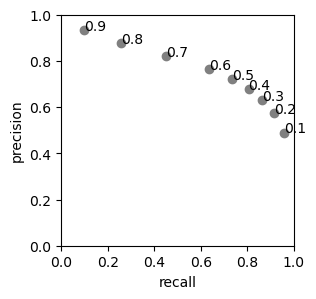

In [28]:
fig = plt.figure(figsize=(3, 3))
for thres in np.arange(.1, 1, .1):
    _rp = metr(targets_train.flatten(), predictions_train.flatten()>thres)
    _rec = _rp['tpr']
    _prec = _rp['prec']
    plt.scatter(_rec, _prec, c='gray');
    plt.text(_rec, _prec, round(thres, 1));
plt.xlabel("recall"); plt.ylabel("precision"); plt.xlim(0,1); plt.ylim(0,1);

In [30]:
R_train = []
for thres in pbar(np.linspace(0, .99, 100)):
    r = [metr(targets_train[:,c], predictions_train[:,c] >= thres) for c in range(targets_train.shape[-1])]
    r = pd.DataFrame(r)
    R_train.append(r)

R_train = np.array([r.values for r in R_train])
R_train.shape

100% (100 of 100) |######################| Elapsed Time: 0:00:33 Time:  0:00:330003


(100, 24, 2)

<Figure size 640x480 with 0 Axes>

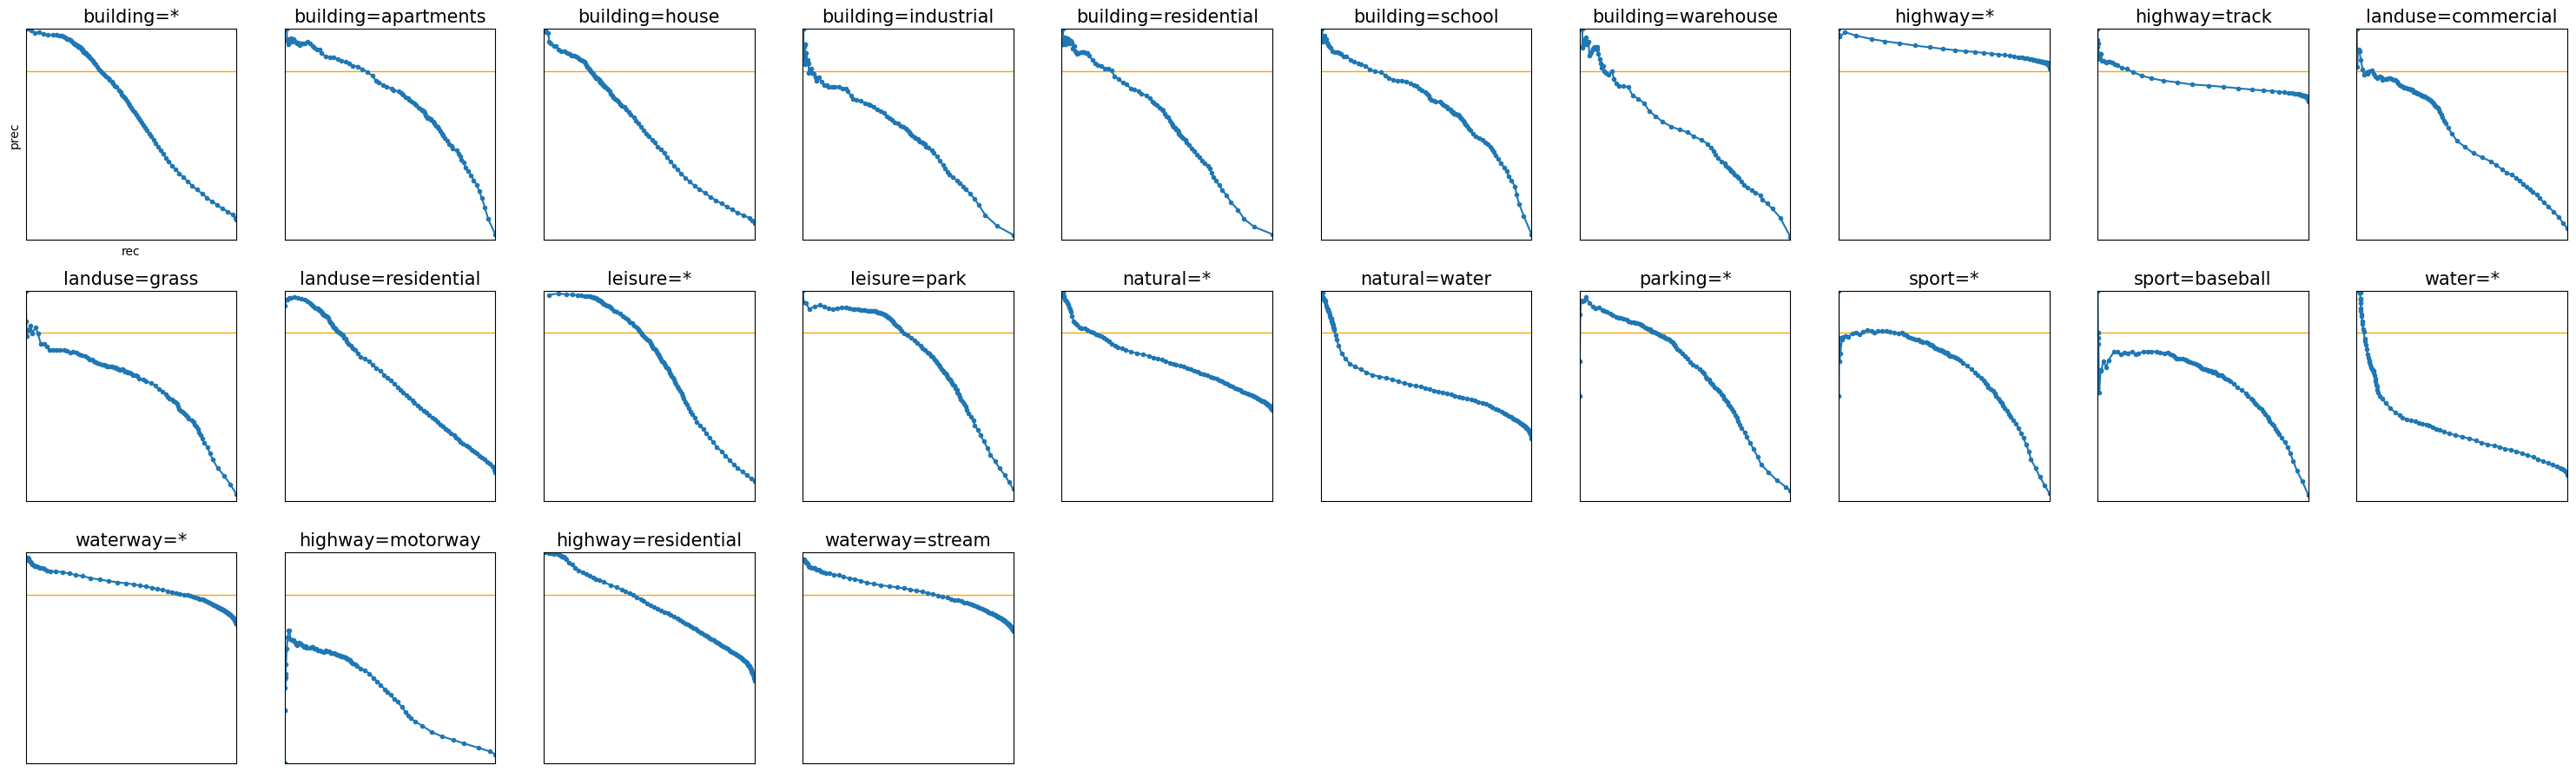

In [31]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=10, usizex=3, usizey=3):
    ax.plot([0,1], [.8,.8], lw=1, c='orange');
    ax.set_title(name_dict[classes_retain[c]], fontsize=15);
    ax.set_xlim(0, 1); ax.set_ylim(0, 1);
    ax.set_yticks([]); ax.set_xticks([]);
    ax.set_aspect('equal')
    if c == 0:
        ax.set_xlabel('rec', fontsize=10); ax.set_ylabel('prec', fontsize=10);
    ax.plot(*R_train[:, c, :].T, marker='o', ls='-', markersize=3);
    # for i, thres in enumerate(np.linspace(0.1, 1, 10)):
    #     if None not in R_train[i, c, :] and np.isfinite(list(R_train[i, c, :])).all():
    #         ax.text(*R_train[i, c, :], f"{thres:.1f}", fontsize=10)
plt.tight_layout();

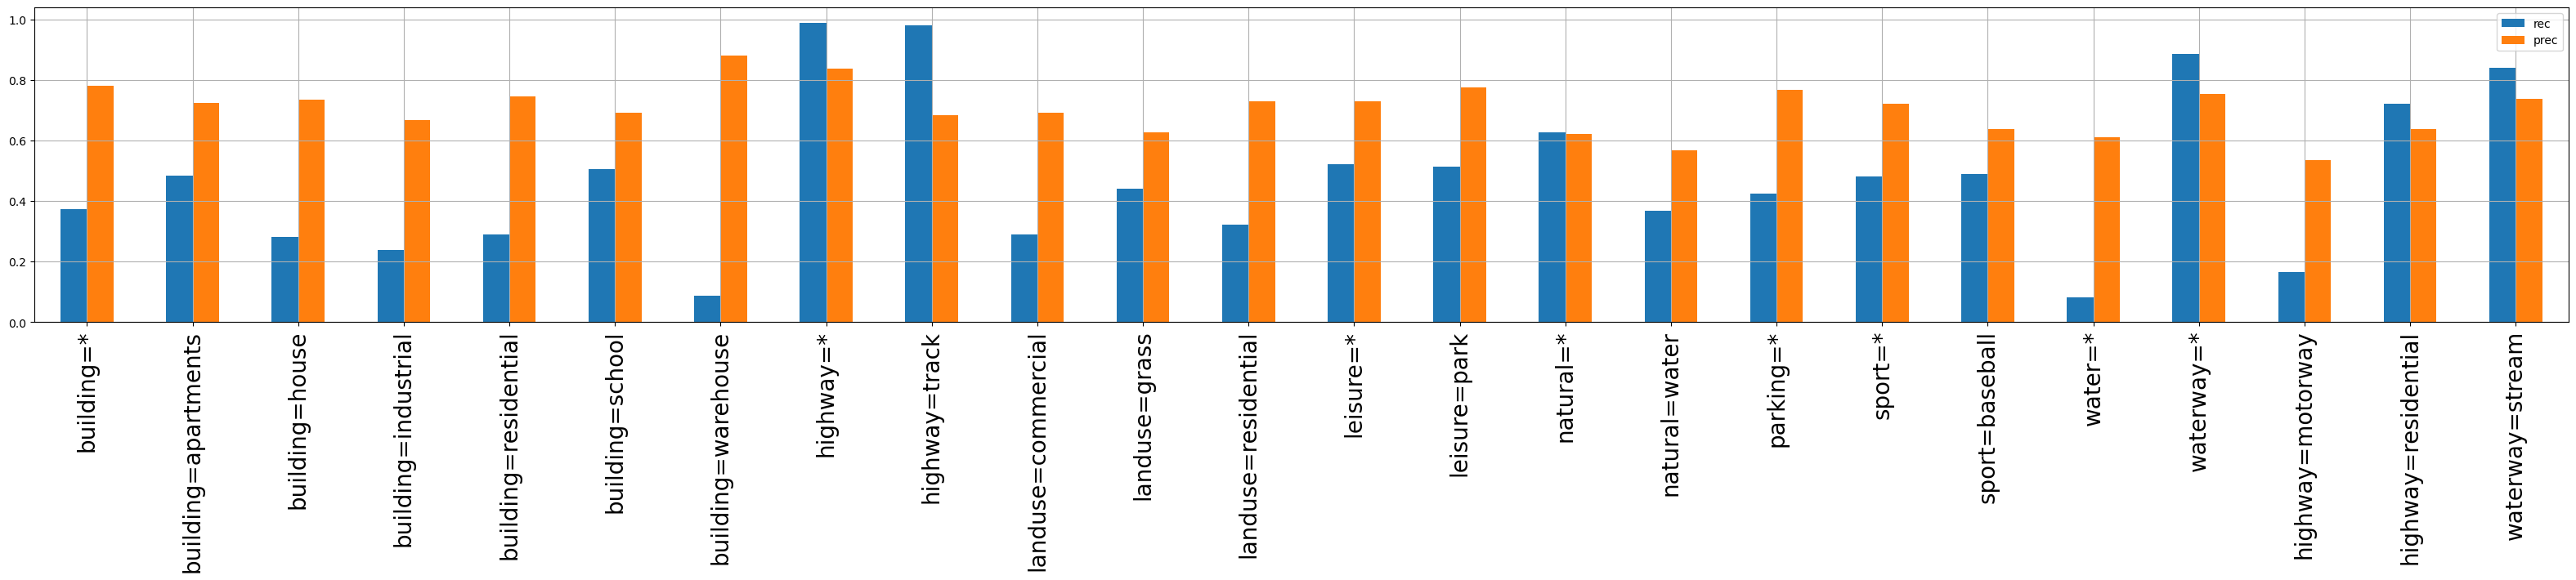

In [32]:
ax = pd.DataFrame(R_train[50], columns=['rec', 'prec']).plot(kind='bar', figsize=(40,5), grid=True);
ax.set_xticklabels(labels=(name_dict[classes_retain[i]] for i in range(len(classes_retain))), rotation=90, fontsize=20);

<Figure size 640x480 with 0 Axes>

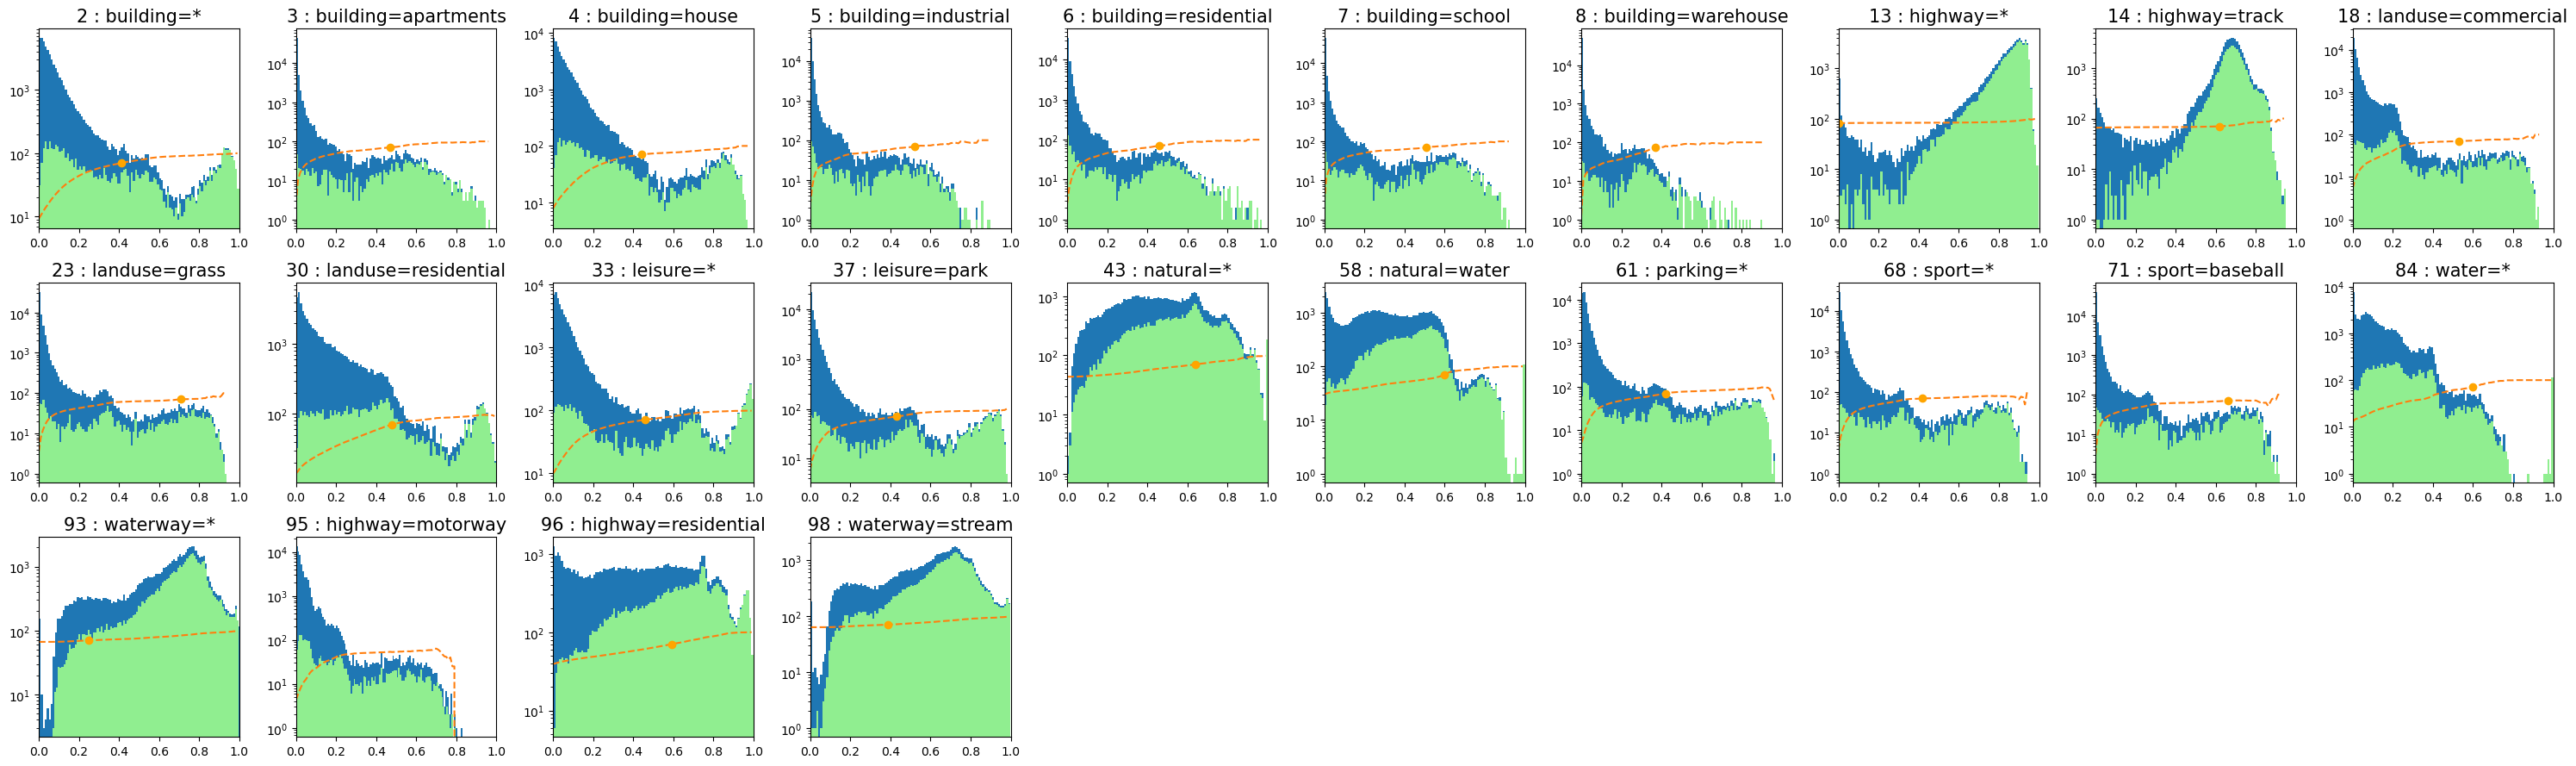

In [34]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=10, usizex=3, usizey=3):
    plt.hist(predictions_train[:, c], bins=100);
    plt.hist(predictions_train[targets_train[:, c] > 0, c], bins=100, color='lightgreen');
    plt.plot(np.linspace(0, .99, 100), R_train[:, c, 1]*100, '--');
    is_high_prec = (R_train[:, c, 1] >= .7)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        plt.plot(i_nz/100, R_train[i_nz, c, 1]*100, 'o', color='orange');
    plt.yscale('log');
    plt.xlim(0,1); plt.title(f"{classes_retain[c]} : {name_dict[classes_retain[c]]}", fontsize=15);

#### Modify the labels for instances of low precision

In [42]:
print(conf.dataloader.metadata_file)
df = gp.read_parquet(conf.dataloader.metadata_file)

/opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels.parquet


In [43]:
prob_cutoff = {}
for i, c in enumerate(classes_retain):
    is_high_prec = (R_train[:, i, 1] >= .7)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        prob_cutoff[c] = i_nz / 100
    else:
        prob_cutoff[c] = .5

print(len(prob_cutoff))
print(prob_cutoff)

df_modified = df.copy()
targets2_train = targets_train.copy()
for i, c in enumerate(prob_cutoff):
    alter_mask = (predictions_train[:, i] < prob_cutoff[c])
    targets2_train[alter_mask, i] = 0
    print(c, name_dict[c])
    if alter_mask.sum() > 0:
        alter_IDs = chip_IDs_train[alter_mask]
        mod_df(df_modified, ix=alter_IDs, c=c)

24
{2: 0.41, 3: 0.47, 4: 0.44, 5: 0.52, 6: 0.46, 7: 0.51, 8: 0.37, 13: 0.0, 14: 0.62, 18: 0.53, 23: 0.71, 30: 0.48, 33: 0.46, 37: 0.43, 43: 0.64, 58: 0.6, 61: 0.42, 68: 0.42, 71: 0.66, 84: 0.6, 93: 0.25, 95: 0.5, 96: 0.59, 98: 0.39}
2 building=*
3 building=apartments
4 building=house
5 building=industrial
6 building=residential
7 building=school
8 building=warehouse
13 highway=*
14 highway=track
18 landuse=commercial
23 landuse=grass
30 landuse=residential
33 leisure=*
37 leisure=park
43 natural=*
58 natural=water
61 parking=*
68 sport=*
71 sport=baseball
84 water=*
93 waterway=*
95 highway=motorway
96 highway=residential
98 waterway=stream


#### Repeat this relabeling process for the val and test datasets

##### Val

In [44]:
targets_val, predictions_val, chip_IDs_val = [], [], []
dlval = dl.val_dataloader()
for batch in pbar(dlval):
    x = batch['embedding']
    t = batch['multilabel'][:, classes_retain]
    cid = batch['chip_id']

    o = m(x)

    for ti in t.detach().numpy():
        targets_val.append(ti)
    for oi in o.detach().numpy():
        predictions_val.append(oi)
    chip_IDs_val.extend(cid)  # +=

targets_val = np.r_[targets_val]
predictions_val = np.r_[predictions_val]
chip_IDs_val = np.r_[chip_IDs_val]
targets_val.shape, predictions_val.shape, chip_IDs_val.shape

100% (739 of 739) |######################| Elapsed Time: 0:00:04 Time:  0:00:040000


((11822, 24), (11822, 24), (11822,))

In [45]:
R_val = []
for thres in pbar(np.linspace(0, .99, 100)):
    r = [metr(targets_val[:,c], predictions_val[:,c] >= thres) for c in range(targets_val.shape[-1])]
    r = pd.DataFrame(r)
    R_val.append(r)

R_val = np.array([r.values for r in R_val])
R_val.shape

100% (100 of 100) |######################| Elapsed Time: 0:00:06 Time:  0:00:060000


(100, 24, 2)

In [46]:
prob_cutoff = {}
for i, c in enumerate(classes_retain):
    is_high_prec = (R_val[:, i, 1] >= .7)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        prob_cutoff[c] = i_nz / 100
    else:
        prob_cutoff[c] = .5

print(len(prob_cutoff))
print(prob_cutoff)

for i, c in enumerate(prob_cutoff):
    alter_mask = (predictions_val[:, i] < prob_cutoff[c])
    print(c, name_dict[c])
    if alter_mask.sum() > 0:
        alter_IDs = chip_IDs_val[alter_mask]
        mod_df(df_modified, ix=alter_IDs, c=c)

24
{2: 0.42, 3: 0.61, 4: 0.81, 5: 0.63, 6: 0.7, 7: 0.56, 8: 0.55, 13: 0.0, 14: 0.6, 18: 0.61, 23: 0.74, 30: 0.57, 33: 0.45, 37: 0.42, 43: 0.66, 58: 0.62, 61: 0.43, 68: 0.39, 71: 0.59, 84: 0.56, 93: 0.18, 95: 0.44, 96: 0.6, 98: 0.47}
2 building=*
3 building=apartments
4 building=house
5 building=industrial
6 building=residential
7 building=school
8 building=warehouse
13 highway=*
14 highway=track
18 landuse=commercial
23 landuse=grass
30 landuse=residential
33 leisure=*
37 leisure=park
43 natural=*
58 natural=water
61 parking=*
68 sport=*
71 sport=baseball
84 water=*
93 waterway=*
95 highway=motorway
96 highway=residential
98 waterway=stream


##### Test

In [47]:
targets_test, predictions_test, chip_IDs_test = [], [], []
dltest = dl.test_dataloader()
for batch in pbar(dltest):
    x = batch['embedding']
    t = batch['multilabel'][:, classes_retain]
    cid = batch['chip_id']

    o = m(x)
    for ti in t.detach().numpy():
        targets_test.append(ti)
    for oi in o.detach().numpy():
        predictions_test.append(oi)
    chip_IDs_test.extend(cid)  # +=

targets_test = np.r_[targets_test]
predictions_test = np.r_[predictions_test]
chip_IDs_test = np.r_[chip_IDs_test]
targets_test.shape, predictions_test.shape, chip_IDs_test.shape

100% (817 of 817) |######################| Elapsed Time: 0:00:04 Time:  0:00:040000


((13071, 24), (13071, 24), (13071,))

In [48]:
R_test = []
for thres in pbar(np.linspace(0, .99, 100)):
    r = [metr(targets_test[:,c], predictions_test[:,c] >= thres) for c in range(targets_test.shape[-1])]
    r = pd.DataFrame(r)
    R_test.append(r)

R_test = np.array([r.values for r in R_test])
R_test.shape

100% (100 of 100) |######################| Elapsed Time: 0:00:07 Time:  0:00:070000


(100, 24, 2)

In [49]:
prob_cutoff = {}
for i, c in enumerate(classes_retain):
    is_high_prec = (R_test[:, i, 1] >= .7)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        prob_cutoff[c] = i_nz / 100
    else:
        prob_cutoff[c] = .5

print(len(prob_cutoff))
print(prob_cutoff)

for i, c in enumerate(prob_cutoff):
    alter_mask = (predictions_test[:, i] < prob_cutoff[c])
    print(c, name_dict[c])
    if alter_mask.sum() > 0:
        alter_IDs = chip_IDs_test[alter_mask]
        mod_df(df_modified, ix=alter_IDs, c=c)

24
{2: 0.43, 3: 0.69, 4: 0.9, 5: 0.5, 6: 0.77, 7: 0.75, 8: 0.5, 13: 0.0, 14: 0.54, 18: 0.52, 23: 0.77, 30: 0.53, 33: 0.45, 37: 0.37, 43: 0.66, 58: 0.62, 61: 0.37, 68: 0.56, 71: 0.75, 84: 0.58, 93: 0.4, 95: 0.56, 96: 0.6, 98: 0.48}
2 building=*
3 building=apartments
4 building=house
5 building=industrial
6 building=residential
7 building=school
8 building=warehouse
13 highway=*
14 highway=track
18 landuse=commercial
23 landuse=grass
30 landuse=residential
33 leisure=*
37 leisure=park
43 natural=*
58 natural=water
61 parking=*
68 sport=*
71 sport=baseball
84 water=*
93 waterway=*
95 highway=motorway
96 highway=residential
98 waterway=stream


---

In [52]:
df_modified.to_parquet(
    "/opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels_mod-prec7pc_emb-v0-2-20240426.parquet"
)

# Retrain on retained classes and modified targets (emb v0.2-20240426)

In [68]:
conf = OmegaConf.load("../../configs/multilabel.yaml")
conf.dataloader.metadata_file = '/opt/data/california-worldcover-chips/\
california-worldcover-chips-osm-multilabels_mod-prec7pc_emb-v0-2-20240426.parquet'
conf.dataloader.batch_size = 16
conf.model.output_dim = len(classes_retain)
conf.dataloader.embeddings_folder = "/opt/data/california-worldcover-chips/embeddings_v0.2-20240426"
dl = hydra.utils.instantiate(conf.dataloader)

2024-05-03 09:46:27.900 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1088 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-05-03 09:46:31.294 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1092 - read train split with 58599 chip files (out of 58690)
2024-05-03 09:46:31.294 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1097 - max cache size is -1
2024-05-03 09:46:31.692 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1088 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-05-03 09:46:32.378 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1092 - read val split with 11822 chip files (out of 11841)
2024-05-03 09:46:32.378 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1097 - max cache size is -1
2024-05-

In [69]:
dltrain = dl.train_dataloader()
m2 = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m2.parameters(), lr=1e-5)
sum([np.product(p.shape) for p in m2.parameters()])

561048

In [459]:
# # Full-dataset batch
# X = torch.Tensor(embeddings)
# T = torch.Tensor(targets2)
# # for batch in pbar(dltrain):
# #     x = batch['embedding']
# #     X = torch.concat([X, x])
# #     t = batch['multilabel'][:, classes_retain]
# #     T = torch.concat([T, t])

# X.shape, T.shape

In [460]:
# n_epochs = 100

# bs = 16
# lossh = []
# for epoch in range(n_epochs):
#     for step, ix in enumerate(list(range(0, len(X)-bs, bs))):
#         x = X[ix:ix+bs]
#         t = T[ix:ix+bs]

#         # run model
#         o = m2(x)

#         # compute losses (complex mse or rmse)
#         loss = - torch.mean(torch.log(o + 1e-5)*t + torch.log(1-o + 1e-5)*(1-t))
        
#         # backpropage and update
#         loss.backward()
#         optimizer.step()

#         # cosmetics
#         lossn = loss.detach().cpu().numpy()
#         lossh.append(lossn)
#         psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m2.parameters()])    
#         lossm = np.mean(lossh[-50:])
#         print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")

#     print()

In [70]:
n_epochs = 200

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = batch['embedding']
        t = batch['multilabel'][:, classes_retain]

        # run model
        o = m2(x)

        # compute losses (complex mse or rmse)
        loss = - torch.mean(torch.log(o + 1e-5)*t + torch.log(1-o + 1e-5)*(1-t))
        
        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 3662 loss 0.22331 params 2.5231853
epoch   1 step 3662 loss 0.17955 params 2.5231853
epoch   2 step 3662 loss 0.17590 params 2.5231853
epoch   3 step 3662 loss 0.17528 params 2.5231853
epoch   4 step 3662 loss 0.17351 params 2.5231853
epoch   5 step 3662 loss 0.19040 params 2.5231853
epoch   6 step 3662 loss 0.16777 params 2.5231853
epoch   7 step 3662 loss 0.17123 params 2.5231853
epoch   8 step 3662 loss 0.16879 params 2.5231853
epoch   9 step 3662 loss 0.15561 params 2.5231853
epoch  10 step 3662 loss 0.16148 params 2.5231853
epoch  11 step 3662 loss 0.16198 params 2.5231853
epoch  12 step 3662 loss 0.15214 params 2.5231853
epoch  13 step 3662 loss 0.15999 params 2.5231853
epoch  14 step 3662 loss 0.15517 params 2.5231853
epoch  24 step 3662 loss 0.13813 params 2.5231853
epoch  25 step 3662 loss 0.14093 params 2.5231853
epoch  26 step 3662 loss 0.13026 params 2.5231853
epoch  27 step 3662 loss 0.13563 params 2.5231853
epoch  28 step 3662 loss 0.14487 params 2.5231853


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



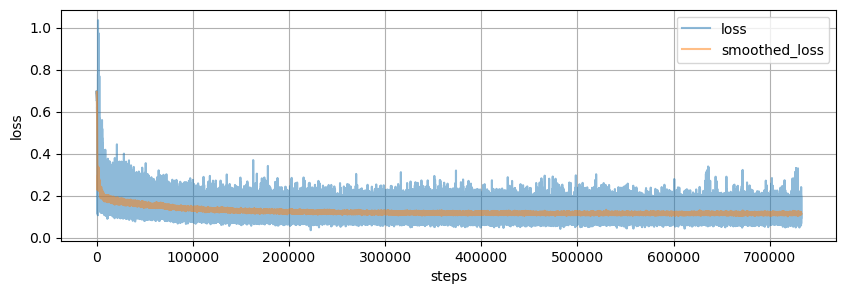

In [73]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss"); #plt.yscale('log');

In [471]:
# predictions2 = m2(X).detach().numpy()
# targets2.shape, predictions2.shape

In [74]:
targets2 = []
predictions2 = []
dltrain = dl.train_dataloader()
for batch in pbar(dltrain):
    x = batch['embedding']
    t = batch['multilabel'][:, classes_retain]
    o = m2(x)

    for ti in t.detach().numpy():
        targets2.append(ti)
    for oi in o.detach().numpy():
        predictions2.append(oi)

targets2 = np.r_[targets2]
predictions2 = np.r_[predictions2]
targets2.shape, predictions2.shape

100% (3663 of 3663) |####################| Elapsed Time: 0:00:15 Time:  0:00:150001


((58599, 24), (58599, 24))

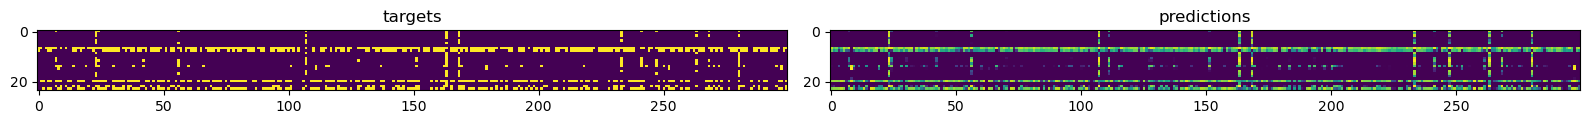

In [75]:
idxs = np.random.permutation(len(targets2))[:300]

for ax, i in subplots(2, usizex=8):
    if i==0: 
        plt.imshow(targets2[idxs].T, interpolation='none')
        plt.title("targets")
    if i==1:
        plt.imshow(predictions2[idxs].T, interpolation='none', vmin=0, vmax=1)
        plt.title("predictions")

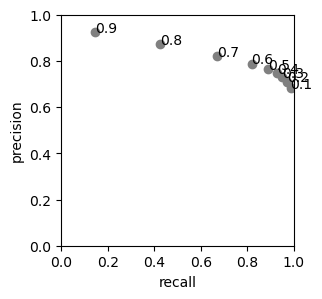

In [76]:
fig = plt.figure(figsize=(3, 3))
for thres in np.arange(.1, 1, .1):
    _rp = metr(targets2.flatten(), predictions2.flatten()>thres)
    _rec = _rp['tpr']
    _prec = _rp['prec']
    plt.scatter(_rec, _prec, c='gray');
    plt.text(_rec, _prec, round(thres, 1));
plt.xlabel("recall"); plt.ylabel("precision"); plt.xlim(0,1); plt.ylim(0,1);

In [77]:
R = []
for thres in pbar(np.linspace(0, .99, 100)):
    r = [metr(targets2[:,c], predictions2[:,c] >= thres) for c in range(targets2.shape[-1])]
    r = pd.DataFrame(r)
    R.append(r)

R = np.array([r.values for r in R])
R.shape

100% (100 of 100) |######################| Elapsed Time: 0:00:32 Time:  0:00:320002


(100, 24, 2)

<Figure size 640x480 with 0 Axes>

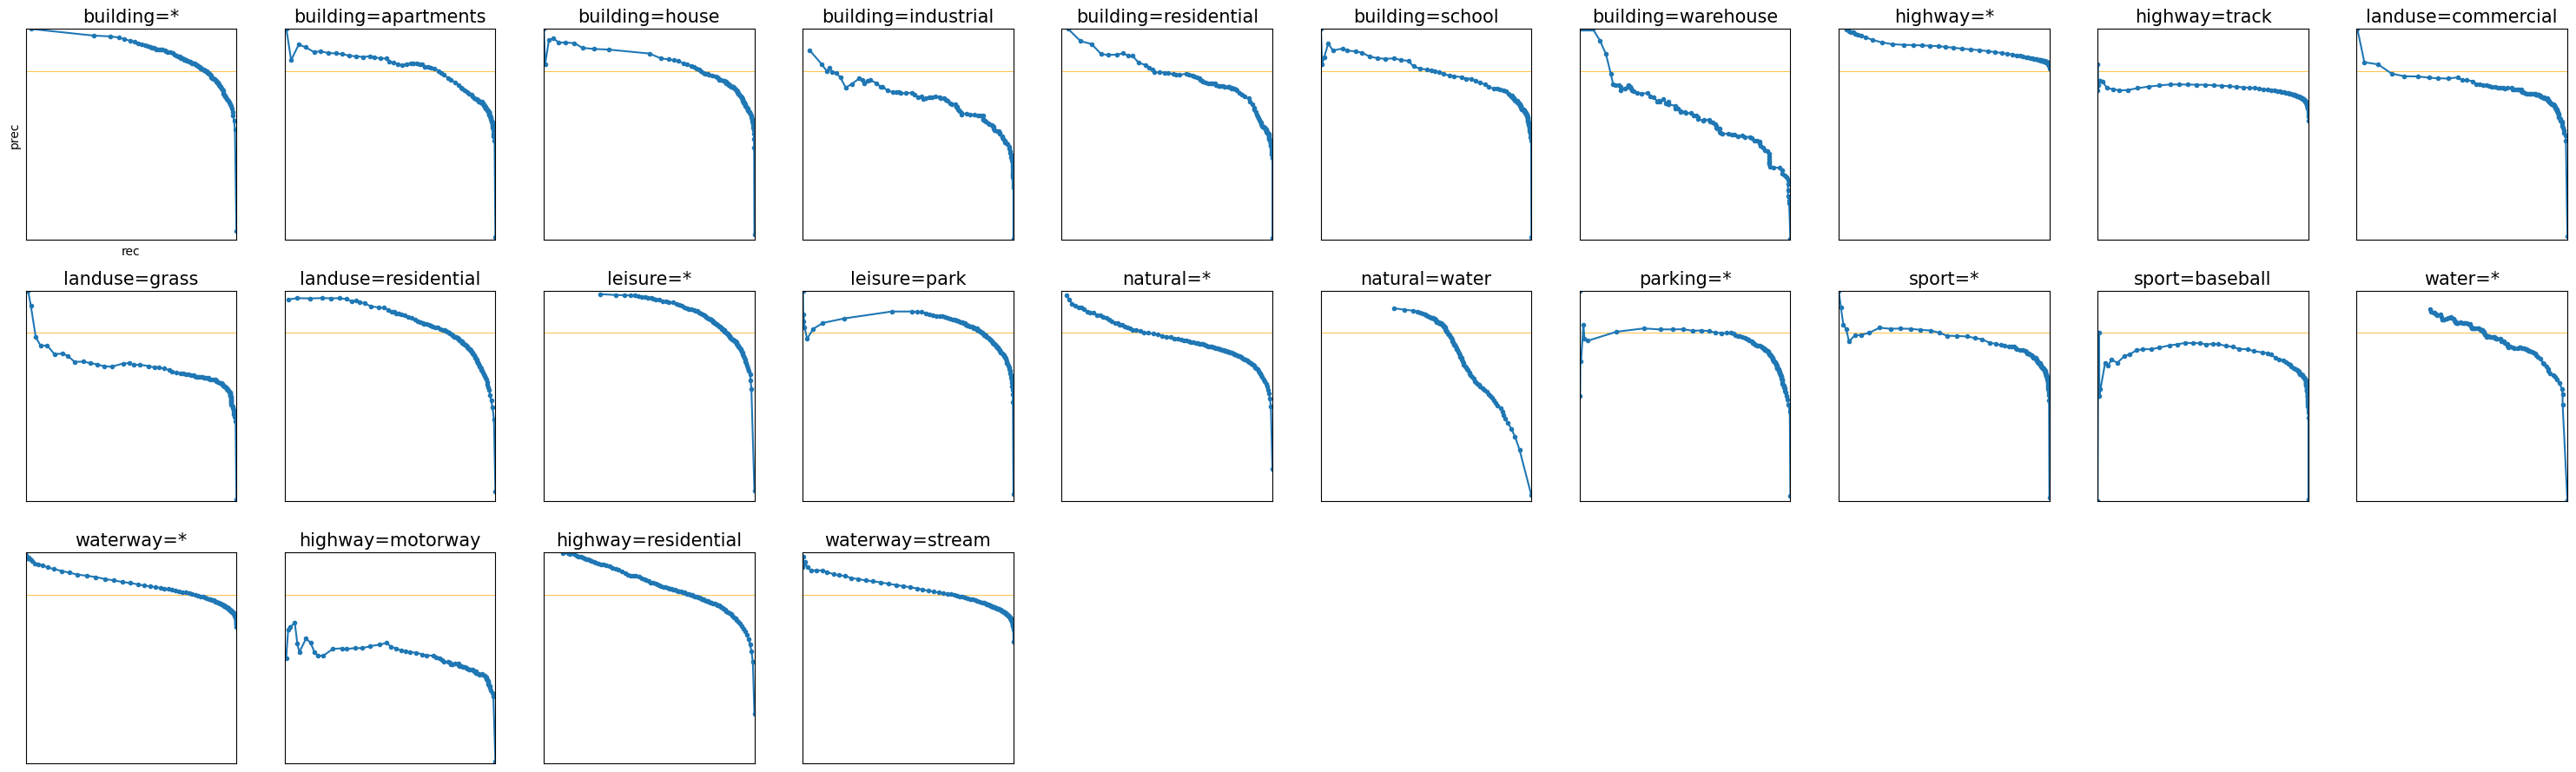

In [78]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=10, usizex=3, usizey=3):
    ax.plot([0,1], [.8,.8], lw=.5, c='orange');
    ax.set_title(name_dict[classes_retain[c]], fontsize=15);
    ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_yticks([]); ax.set_xticks([]); ax.set_aspect('equal');
    if c == 0:
        ax.set_xlabel('rec', fontsize=10); ax.set_ylabel('prec', fontsize=10);
    ax.plot(*R[:, c, :].T, marker='o', ls='-', markersize=3);
plt.tight_layout();

---

All
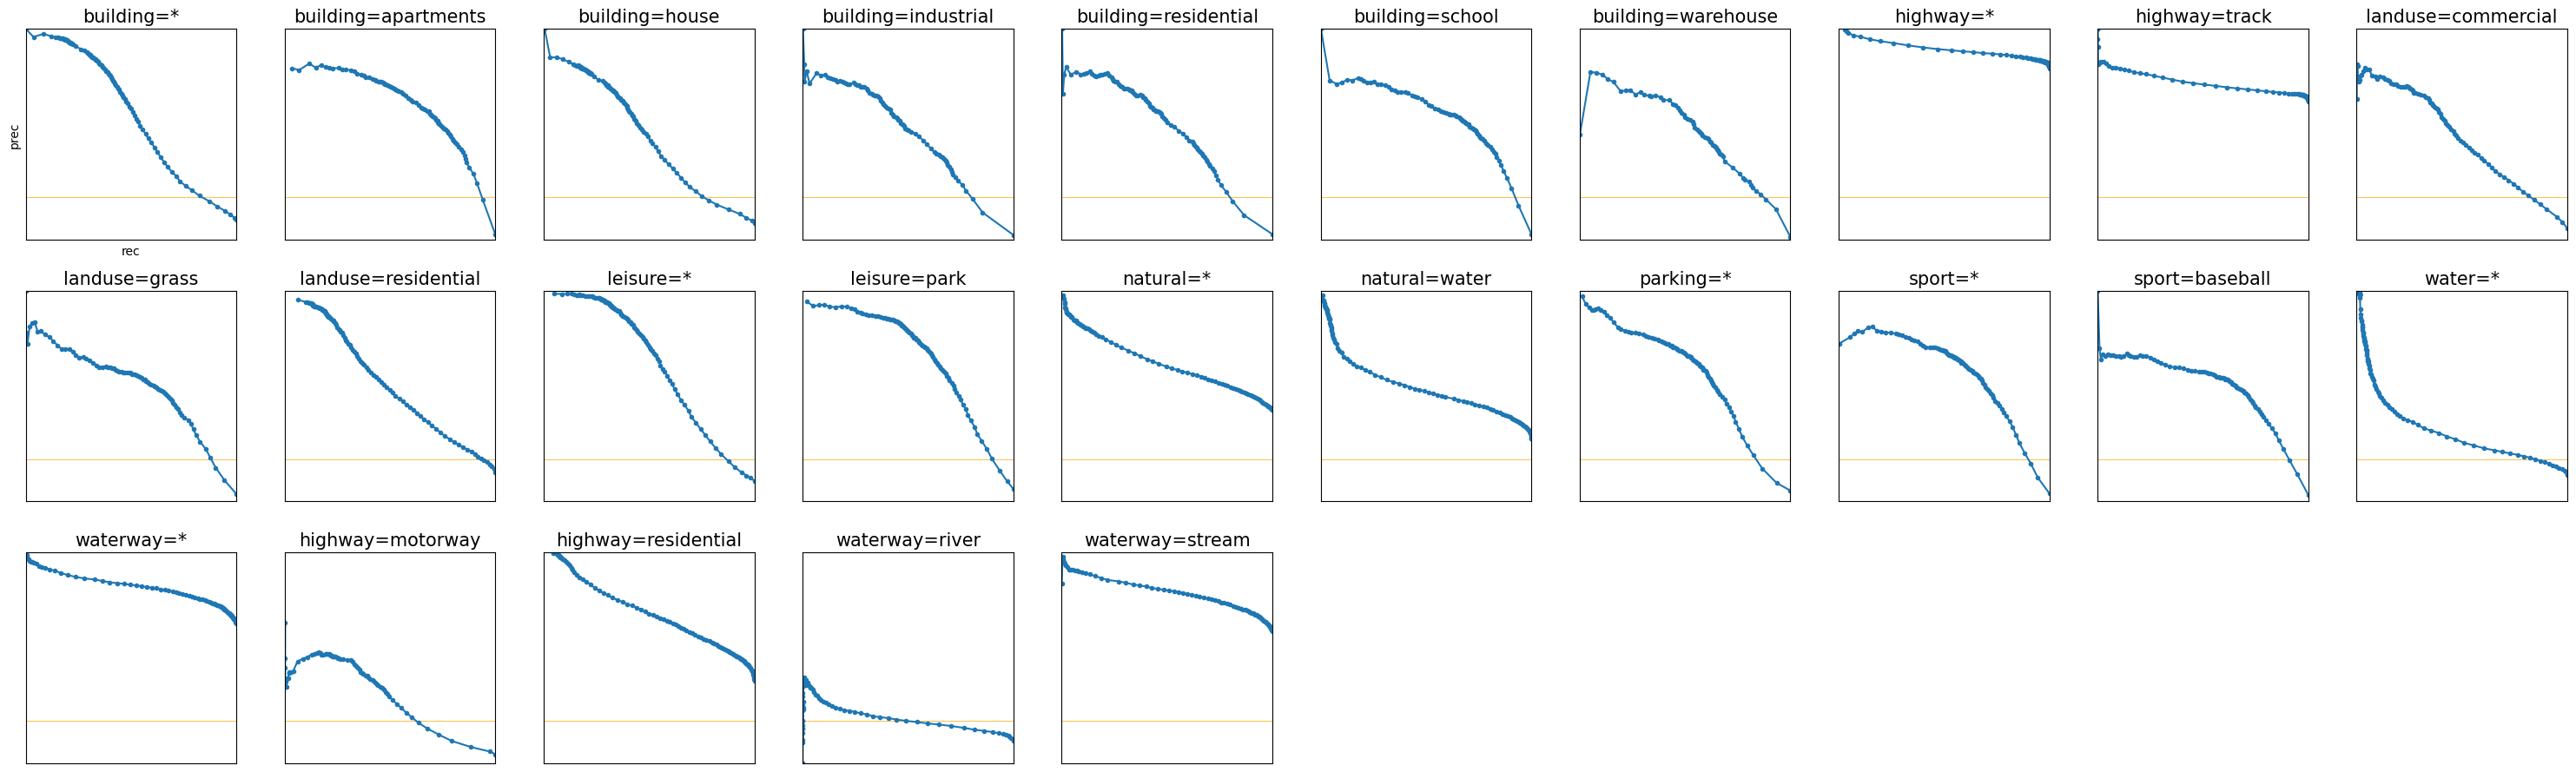


precision >= .4
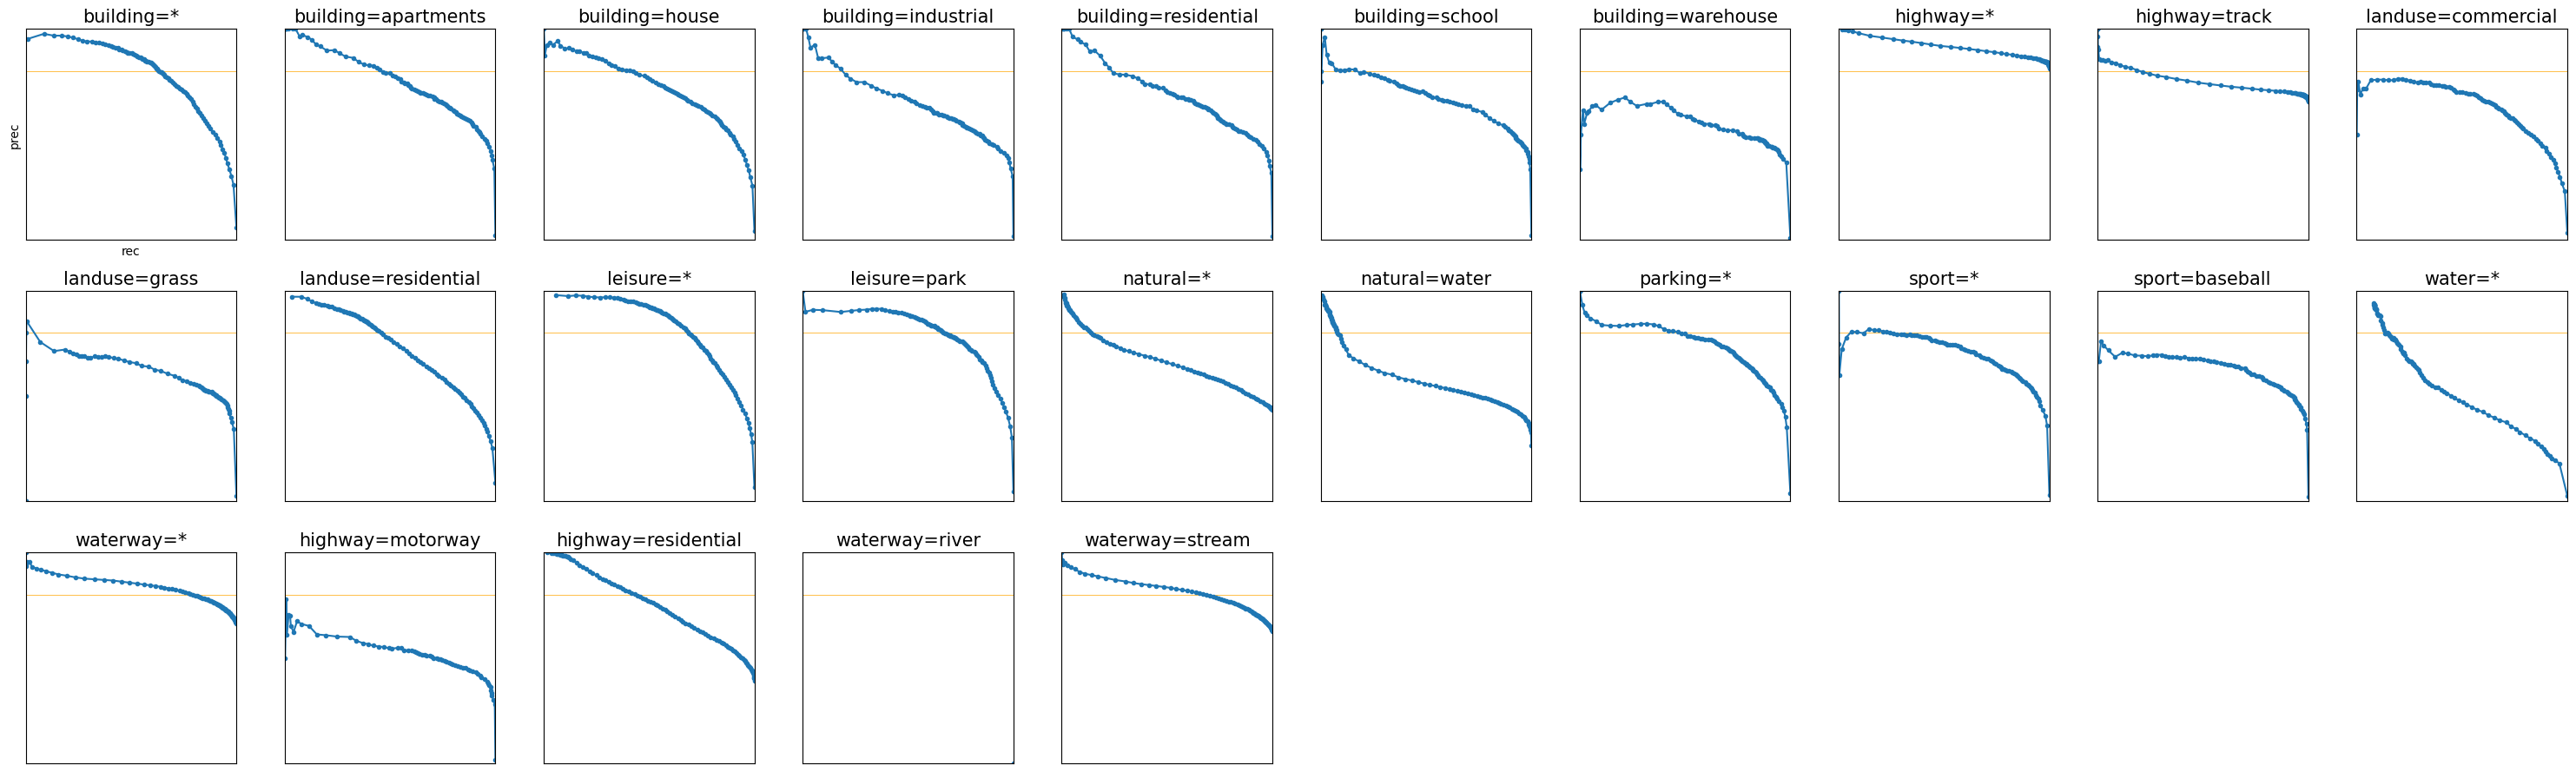

precision >= .7
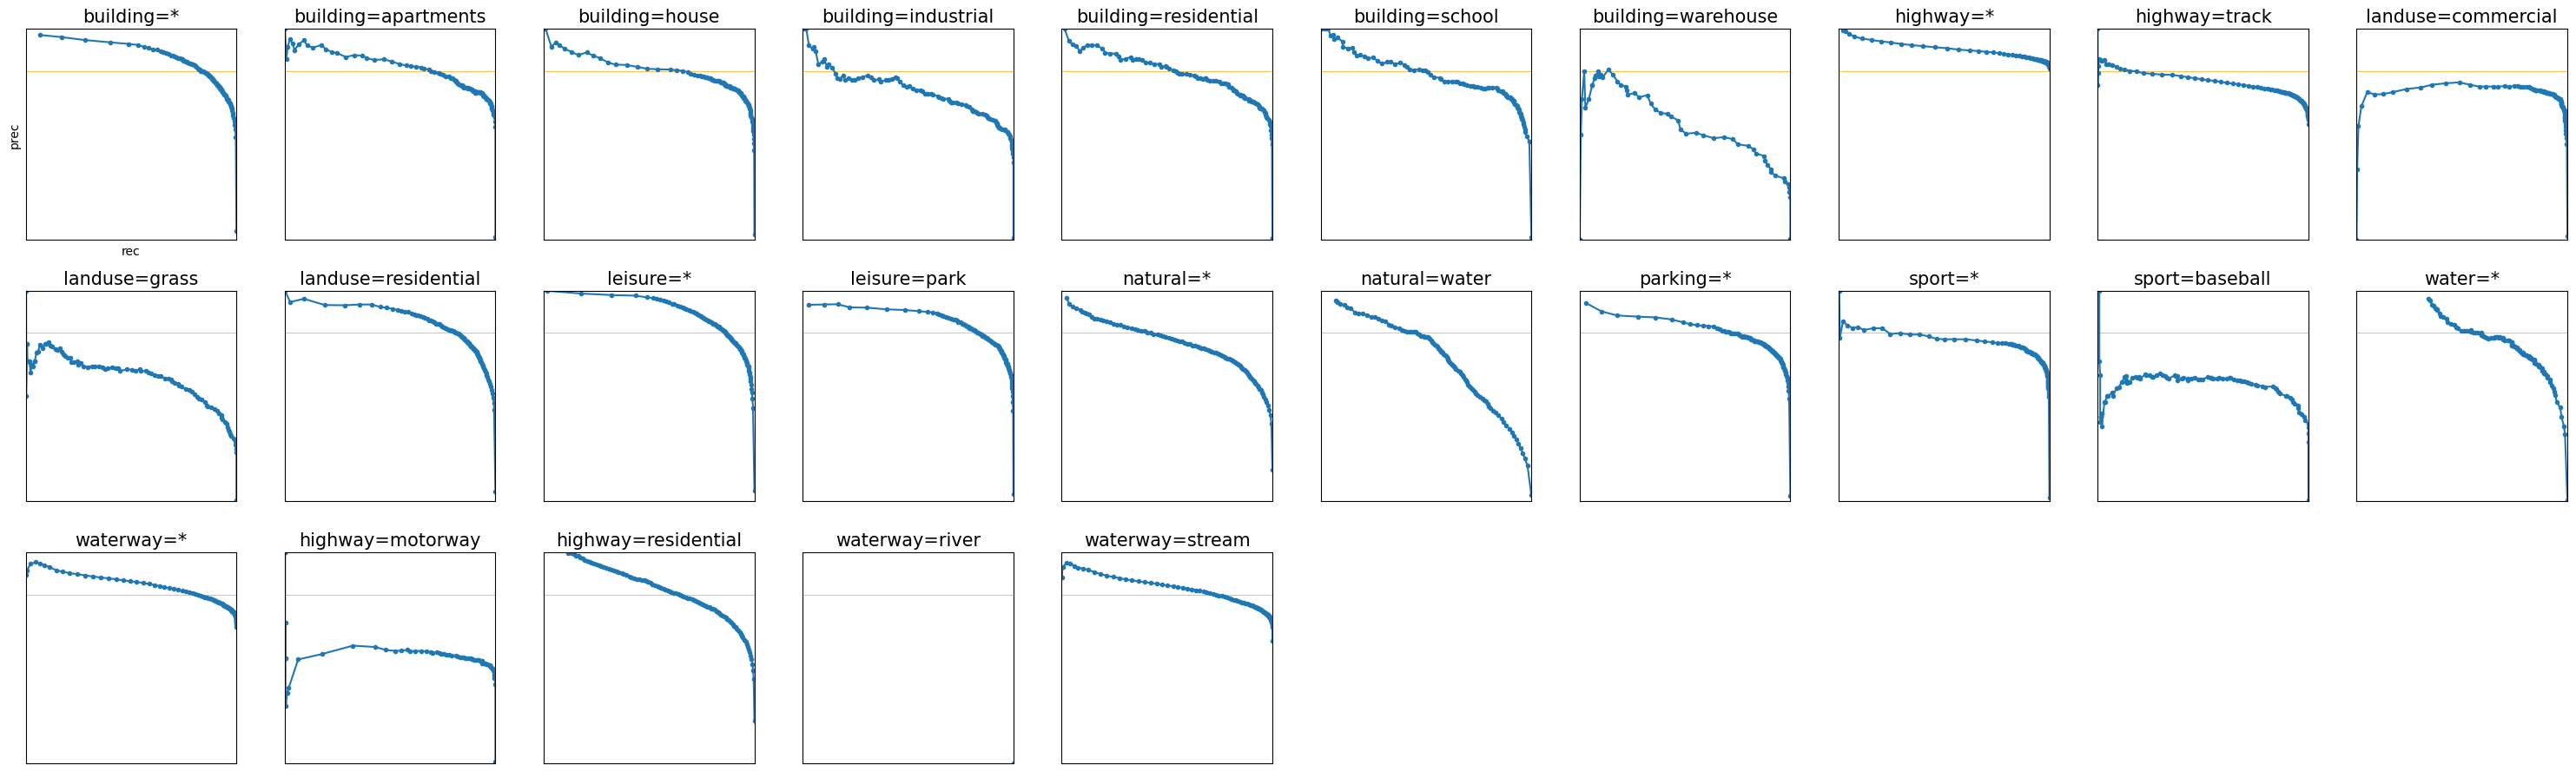

precision >= .7, new embeddings
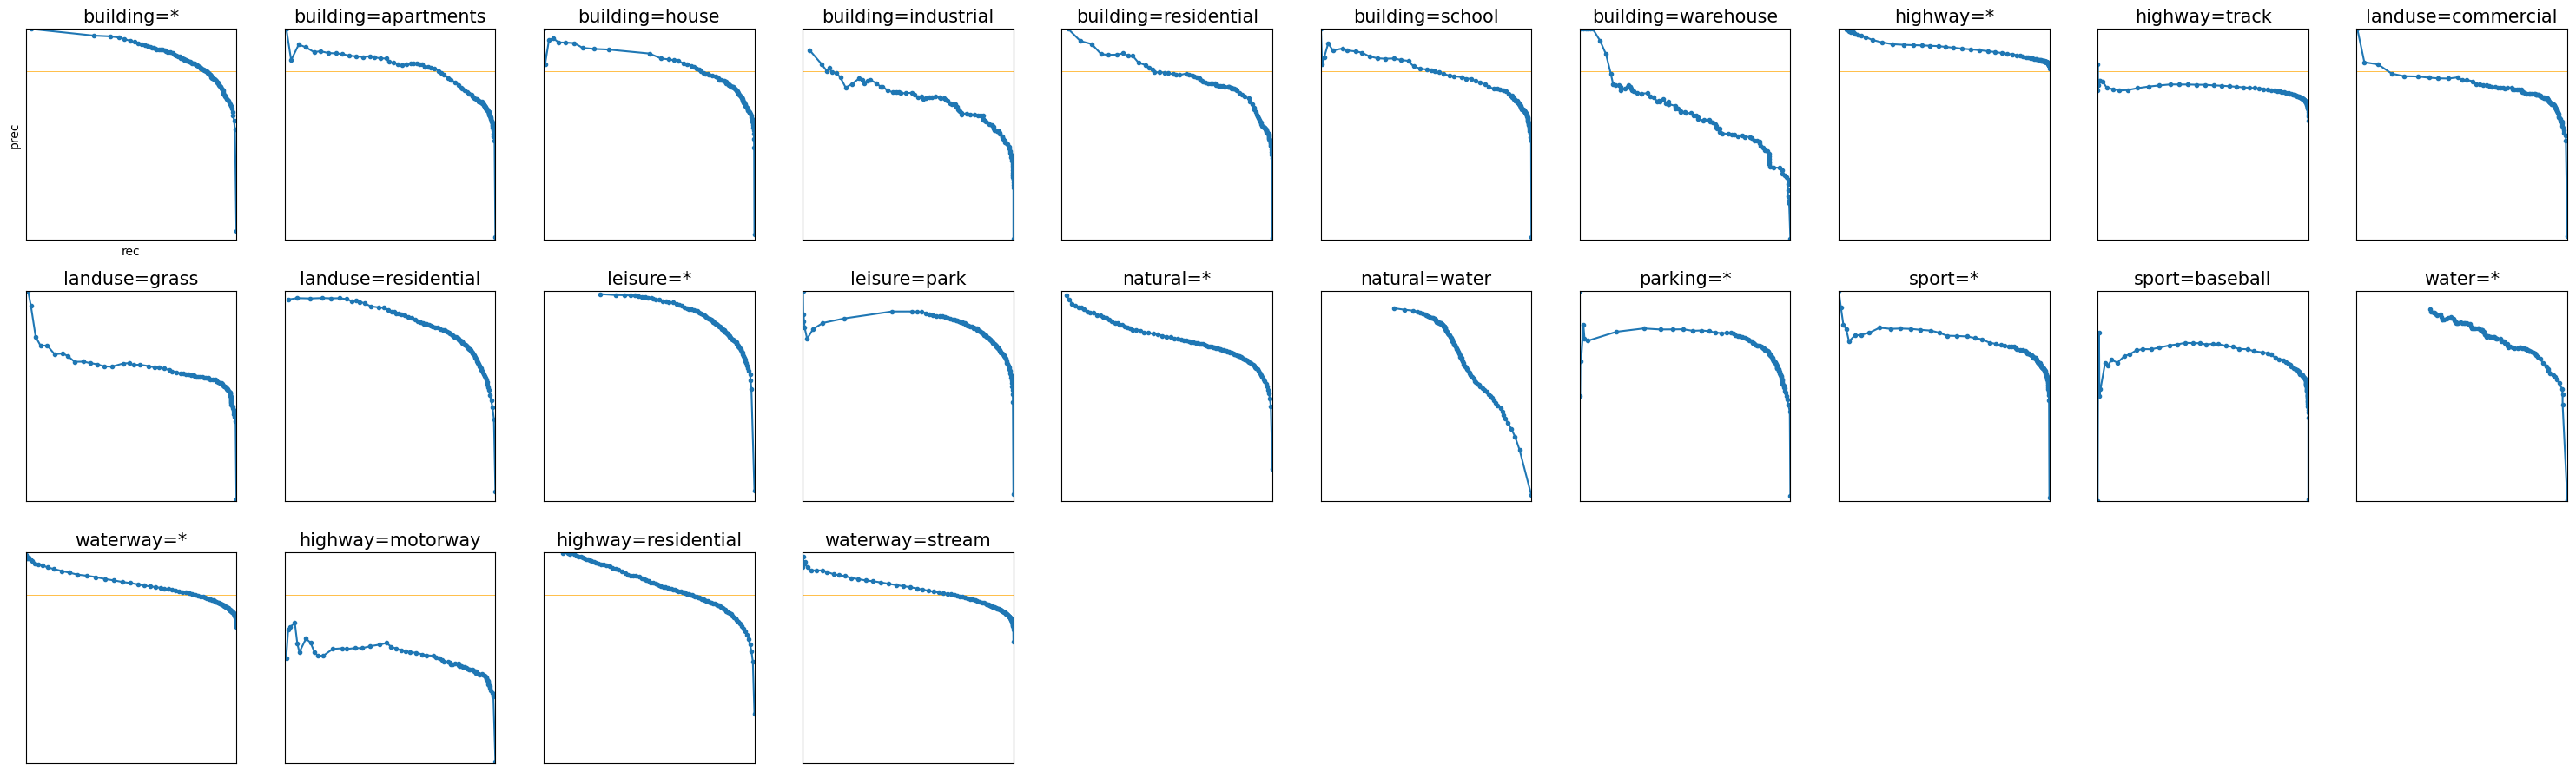

---

<Figure size 640x480 with 0 Axes>

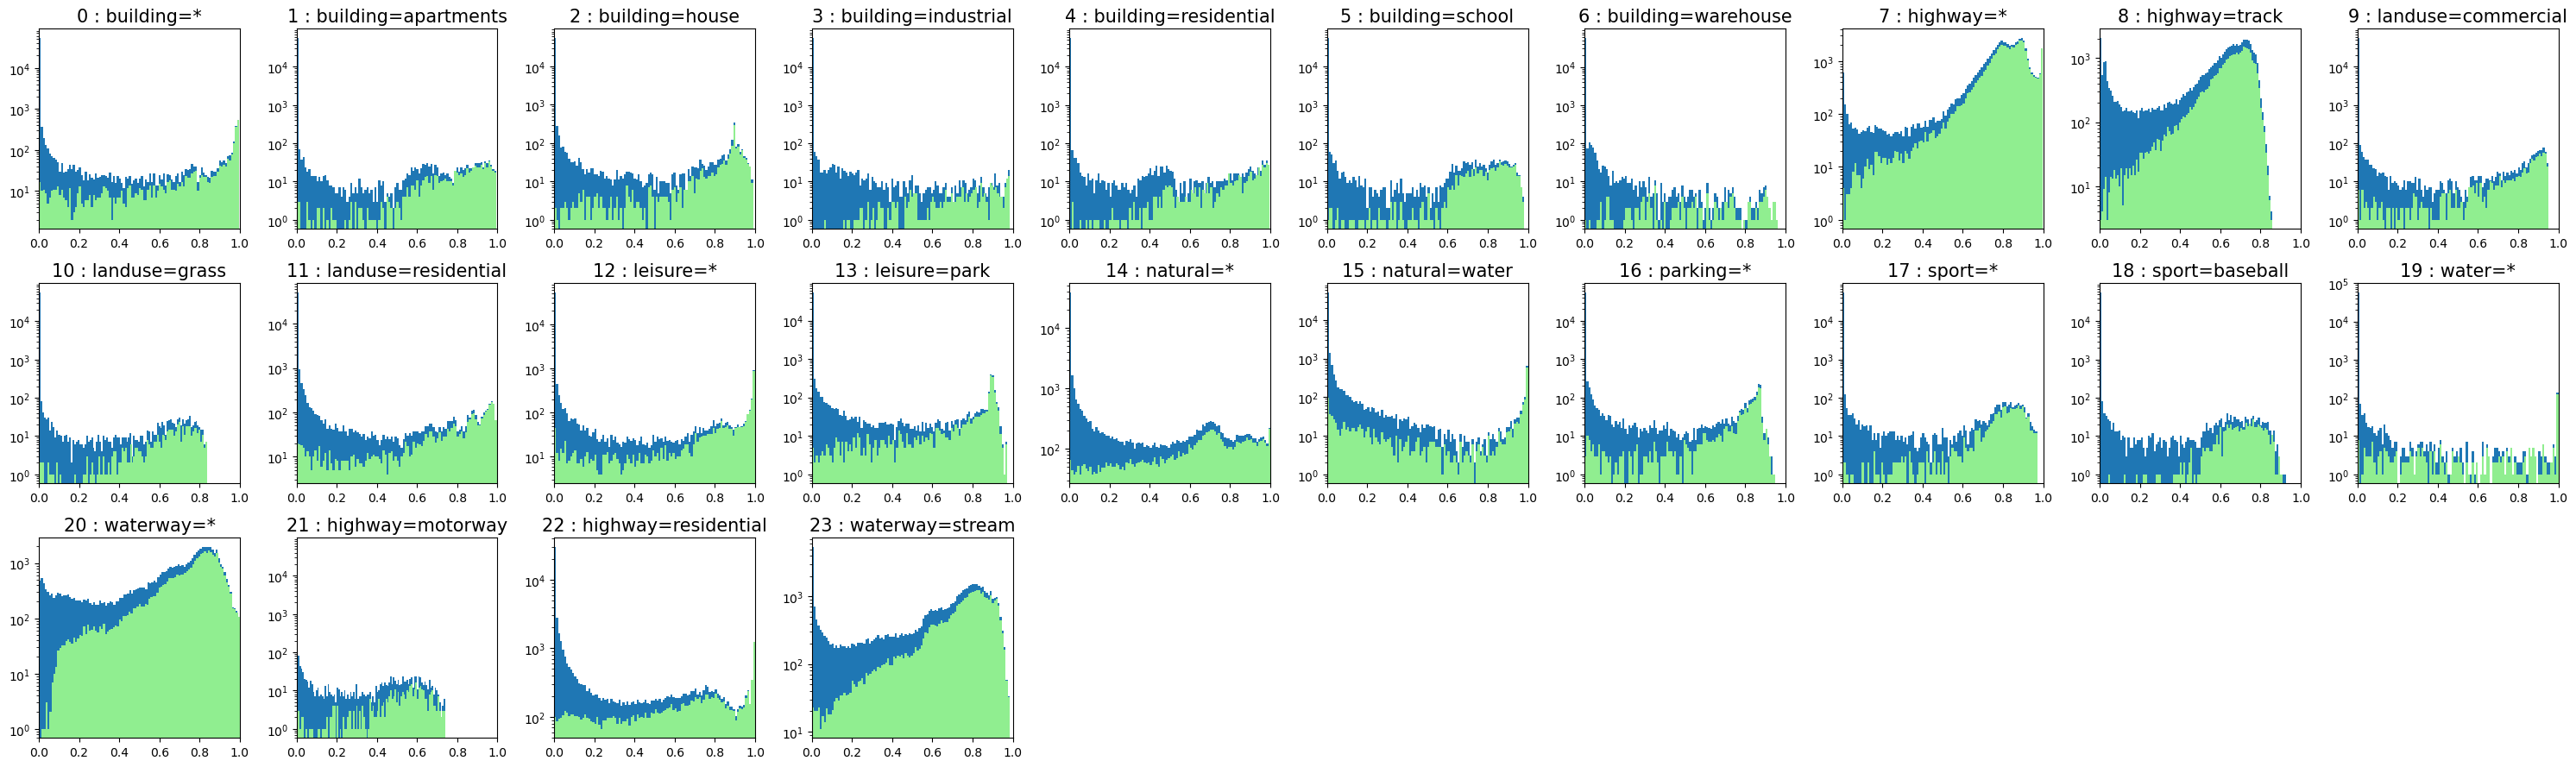

In [79]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=10, usizex=3, usizey=3):
    plt.hist(predictions2[:, c], bins=100);
    plt.hist(predictions2[targets2[:, c] > 0, c], bins=100, color='lightgreen');
    # plt.plot(np.linspace(0, .99, 100), R[:, c, 1]*100, '--');
    # is_high_prec = (R[:, c, 1] >= .4)
    # if is_high_prec.sum() > 0:
    #     i_nz = is_high_prec.nonzero()[0][0]
    #     plt.plot(i_nz/100, R[i_nz, c, 1]*100, 'o', color='orange');
    plt.yscale('log');
    plt.xlim(0,1); plt.title(f"{c} : {name_dict[classes_retain[c]]}", fontsize=15);